# 2.数据预处理

由于分工，本部分包括除特征构建与主成分分析外的数据预处理

## 2.1数据清洗

### 2.1.1查看数据集情况

读入数据并查看数据头几行与数据格式，可以发现earlies_credit_mon,monthly_payment,class,employer_type,industry,work_year几个字段为数据类型为object;work_year,pub_dero_bankrup,f1,f2,f3,f4这几个字段存在缺失值。

In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.ensemble as es
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
data=pd.read_csv('./train_public.csv')
pd.set_option('display.max_columns',None)
data.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1-Dec,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,Apr-90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,Oct-91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1-Jun,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2-May,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   10000 non-null  int64  
 1   user_id                   10000 non-null  int64  
 2   total_loan                10000 non-null  float64
 3   year_of_loan              10000 non-null  int64  
 4   interest                  10000 non-null  float64
 5   monthly_payment           10000 non-null  float64
 6   class                     10000 non-null  object 
 7   employer_type             10000 non-null  object 
 8   industry                  10000 non-null  object 
 9   work_year                 9378 non-null   object 
 10  house_exist               10000 non-null  int64  
 11  censor_status             10000 non-null  int64  
 12  issue_date                10000 non-null  object 
 13  use                       10000 non-null  int64  
 14  post_co

### 2.1.2填补缺失值

打印缺失值占数据总量占比，发现缺失值占比较少。可以用删除或填补的方式处理。经实际检验采用填补方式处理。

In [4]:
list_nan=['work_year','f0','f1','f2','f3','f4','pub_dero_bankrup']
for col in list_nan:
    print('%s: %f' % (col,sum(data[col].isnull())/data.shape[0]))

work_year: 0.062200
f0: 0.049800
f1: 0.085800
f2: 0.049800
f3: 0.049800
f4: 0.049800
pub_dero_bankrup: 0.000700


填补缺失的数据，这里采用众数进行填补。

In [5]:
data1=data.fillna(data.mode().iloc[0]).copy()

### 2.1.3去除重复数据 

可以明显看出数据不存在重复。

In [6]:
print('Numbers of Duplicated:',data1.duplicated().sum())

Numbers of Duplicated: 0


删去作为标识的loan_id,user_id，数据同样不存在重复。

In [7]:
print('Numbers of Duplicated:',data1.drop('loan_id',axis=1).drop('user_id',axis=1).duplicated().sum())

Numbers of Duplicated: 0


## 2.2数据转换

### 2.2.1数据编码

将object类型的标称数据class,employer_type,industry编码为数值数据，采用序号编码

In [8]:
skpe=skp.LabelEncoder()
skpe.fit(data1['class'])
data1['class']=skpe.transform(data1['class'])
skpe.fit(data1['employer_type'])
data1['employer_type']=skpe.transform(data1['employer_type'])
skpe.fit(data1['industry'])
data1['industry']=skpe.transform(data1['industry'])
data1.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.18182,3,11.466,1174.91,2,3,13,3 years,0,1,2016/10/1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1-Dec,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0
1,1025197,225197,28000.00000,5,16.841,670.69,2,3,13,10+ years,0,2,2013/6/1,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,Apr-90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0
2,1009360,209360,17272.72727,3,8.900,603.32,0,3,3,10+ years,1,0,2014/1/1,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,Oct-91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0
3,1039708,239708,20000.00000,3,4.788,602.30,0,1,10,6 years,0,1,2015/7/1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1-Jun,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0
4,1027483,227483,15272.72727,3,12.790,470.31,2,3,2,< 1 year,2,1,2016/7/1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2-May,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0


### 2.2.2时序数据处理

将work_year转化为数字类型，其中10+为10，<1为0

In [9]:
work_year=[]
for i in data1['work_year'].values.tolist():
    tmp=str(i).split(' ')
    if tmp[0]=='10+':
        work_year.append(10)
    elif tmp[0]=='<':
        work_year.append(0)
    else:
        work_year.append(int(tmp[0]))
work_year=pd.Series(work_year)
data1['work_year']=work_year.values
data1['work_year'].head()

0     3
1    10
2    10
3     6
4     0
Name: work_year, dtype: int64

处理issue_date，将issue_date拆分为issue_year与issue_month两个字段，前者为年，后者为月

In [10]:
data1['issue_date']=pd.to_datetime(data1['issue_date'],format='%Y/%m/%d')
data1['issue_year']=data1['issue_date'].dt.year
data1['issue_month']=data1['issue_date'].dt.month
data1=data1.drop('issue_date',axis=1)

处理earlies_credit_mon，同样将其处理为earlies_credit_year与earlies_credit_mon两个字段。

In [11]:
def earlies_credit_year_work(x):
    if x<22:
        x+=2000
    elif 22<x<100:
        x+=1900
    return x
earlies_credit_month=[]
earlies_credit_year=[]
earlies_credit_month_dict={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
for i in data1['earlies_credit_mon'].values.tolist():
    tmp=str(i).split('-')
    if tmp[0] in earlies_credit_month_dict:
        earlies_credit_month.append(earlies_credit_month_dict[tmp[0]])
        earlies_credit_year.append(earlies_credit_year_work(int(tmp[1])))
    elif tmp[1] in earlies_credit_month_dict:
        earlies_credit_month.append(earlies_credit_month_dict[tmp[1]])
        earlies_credit_year.append(np.nan)
data1['earlies_credit_mon']=earlies_credit_month
data1['earlies_credit_year']=earlies_credit_year
data1=data1.fillna(2000)
data1=data1.drop('policy_code',axis=1)
data1.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_year,issue_month,earlies_credit_year
0,1040418,240418,31818.18182,3,11.466,1174.91,2,3,13,3,0,1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,12,5,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0,2016,10,2000.0
1,1025197,225197,28000.00000,5,16.841,670.69,2,3,13,10,0,2,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,4,40642,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0,2013,6,1990.0
2,1009360,209360,17272.72727,3,8.900,603.32,0,3,3,10,1,0,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,10,154,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0,2014,1,1991.0
3,1039708,239708,20000.00000,3,4.788,602.30,0,1,10,6,0,1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,6,0,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0,2015,7,2000.0
4,1027483,227483,15272.72727,3,12.790,470.31,2,3,2,0,2,1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,5,0,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0,2016,7,2000.0


## 2.3异常值识别与处理

由于数据未必符合正态分布，而Z-score等方式检验异常需要数据符合正态分布，因此首先采用K-S检验来检验数据是否符合正态分布

In [12]:
for col in data1.columns:
    print(col,stats.kstest(data1[col], stats.norm.cdf))
    

loan_id KstestResult(statistic=1.0, pvalue=0.0)
user_id KstestResult(statistic=1.0, pvalue=0.0)
total_loan KstestResult(statistic=1.0, pvalue=0.0)
year_of_loan KstestResult(statistic=0.9986501019683699, pvalue=0.0)
interest KstestResult(statistic=0.999999119154028, pvalue=0.0)
monthly_payment KstestResult(statistic=1.0, pvalue=0.0)
class KstestResult(statistic=0.6715447460685429, pvalue=0.0)
employer_type KstestResult(statistic=0.8272498680518208, pvalue=0.0)
industry KstestResult(statistic=0.8373498680518208, pvalue=0.0)
work_year KstestResult(statistic=0.8336498680518207, pvalue=0.0)
house_exist KstestResult(statistic=0.5, pvalue=0.0)
censor_status KstestResult(statistic=0.5383447460685429, pvalue=0.0)
use KstestResult(statistic=0.5, pvalue=0.0)
post_code KstestResult(statistic=0.9927683287581669, pvalue=0.0)
region KstestResult(statistic=0.9411498680518208, pvalue=0.0)
debt_loan_ratio KstestResult(statistic=0.9770330261969594, pvalue=0.0)
del_in_18month KstestResult(statistic=0.5, p

显然，所有字段都不符合正态分布，因此无法使用3sigmode原则来检验数据是否异常。

绘制箱线图检测异常。

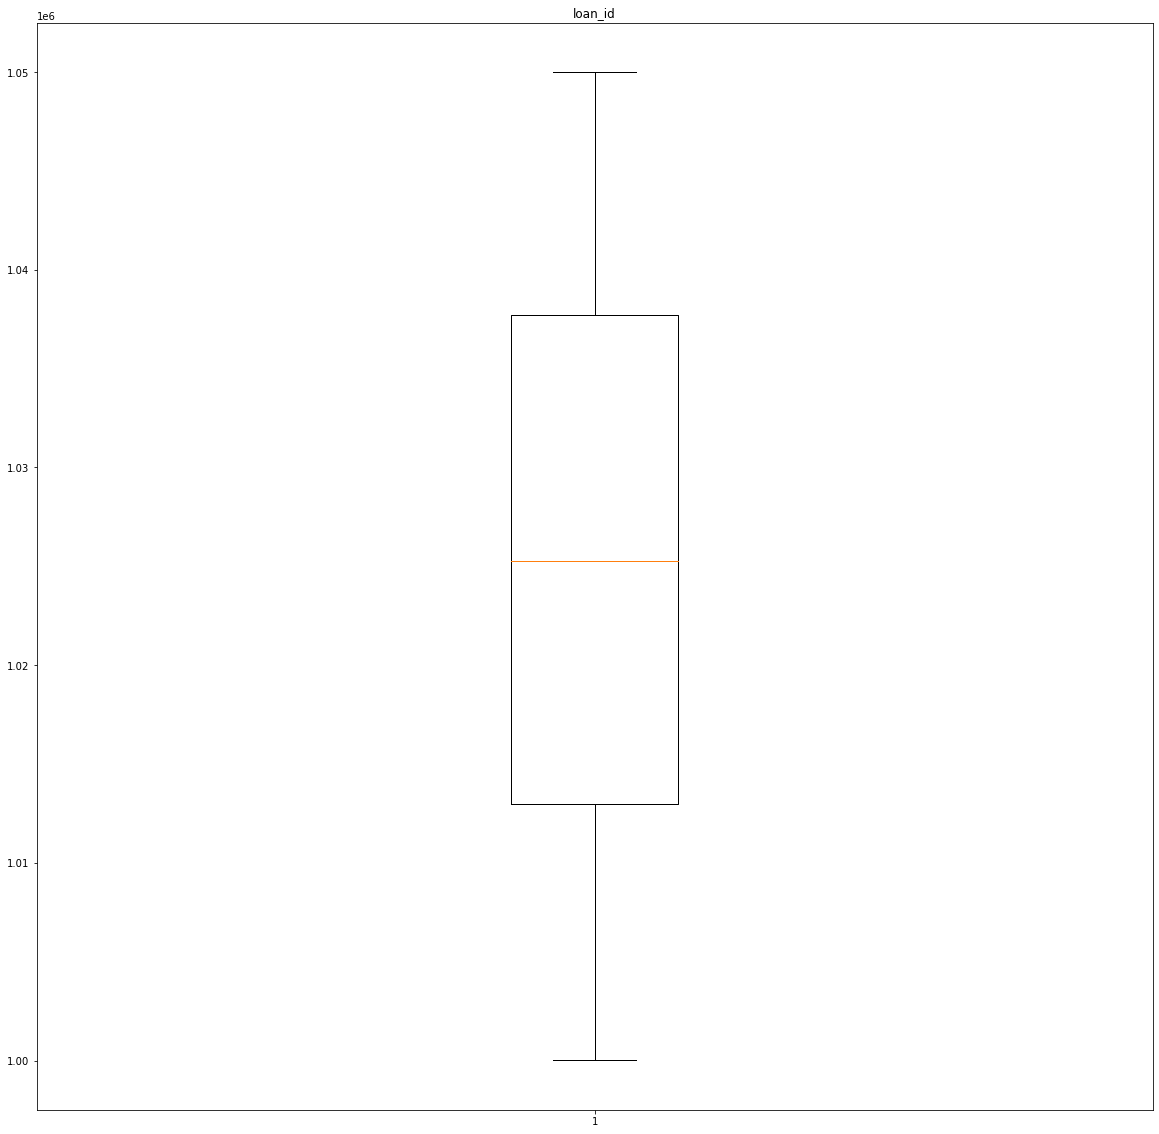

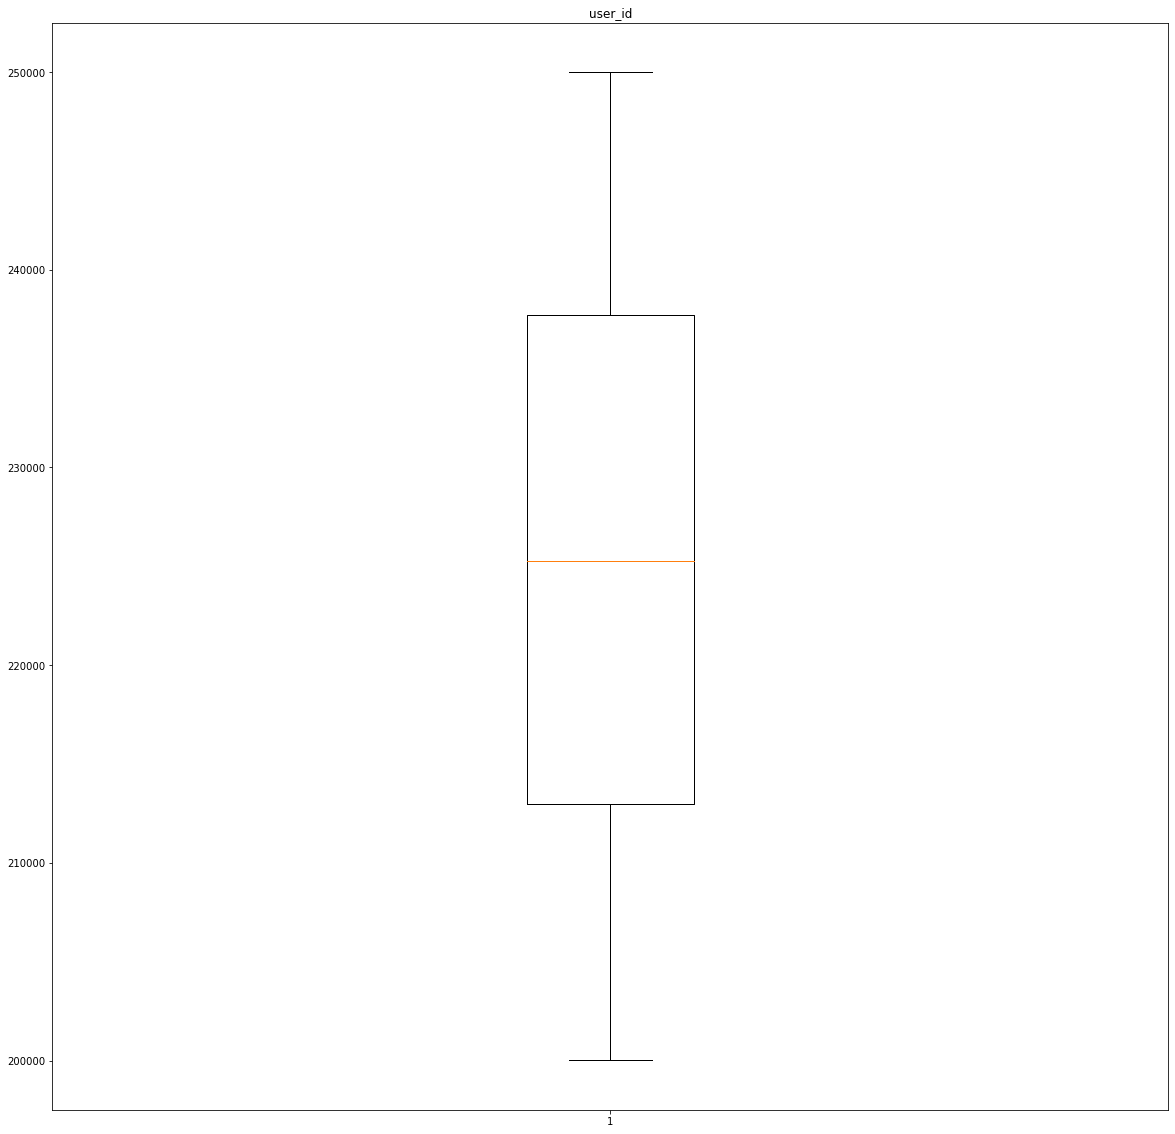

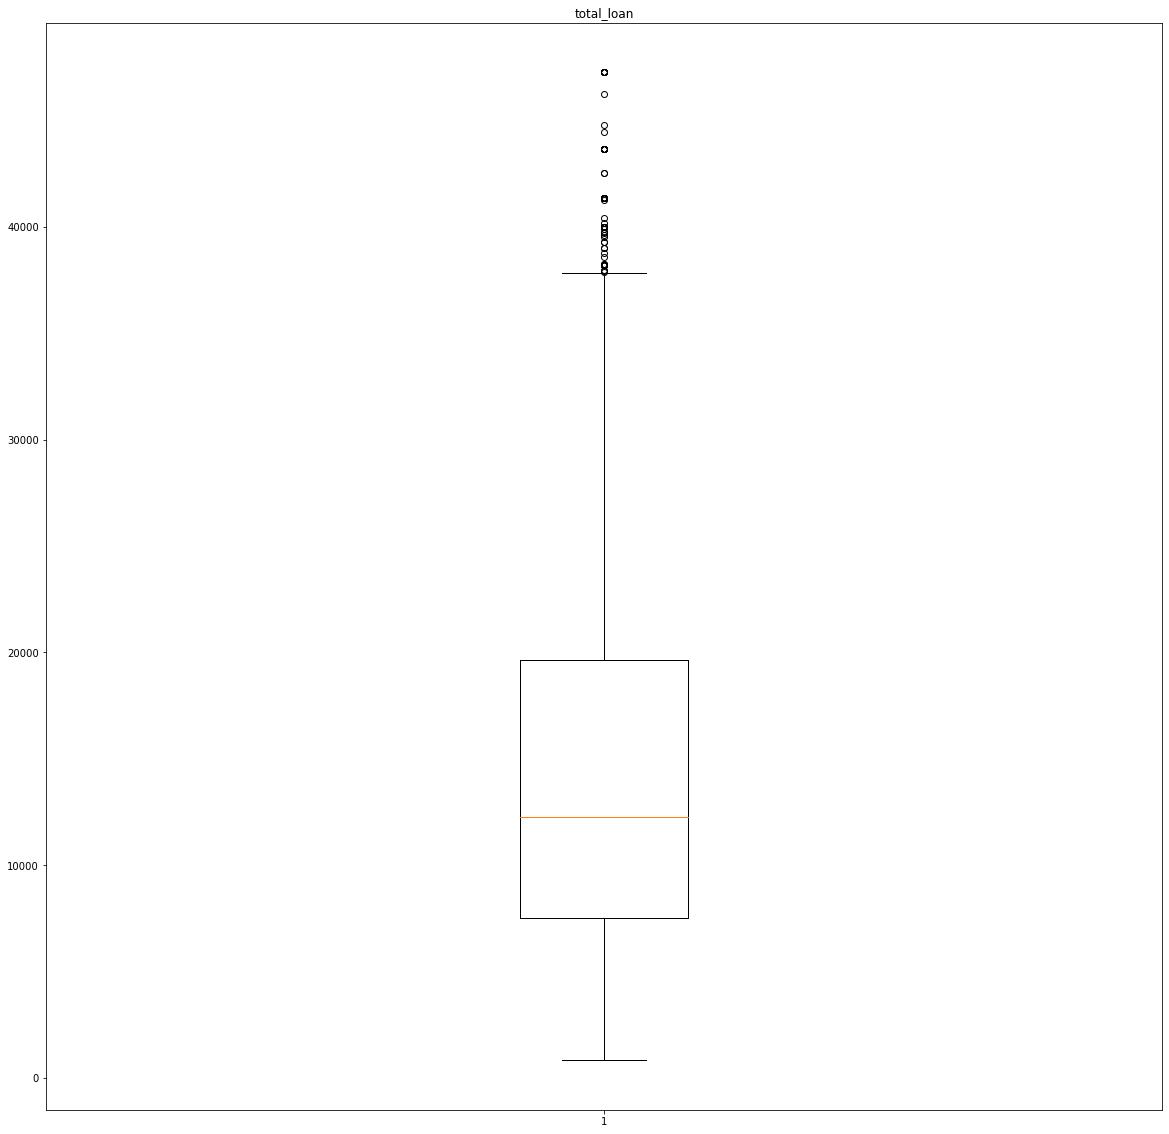

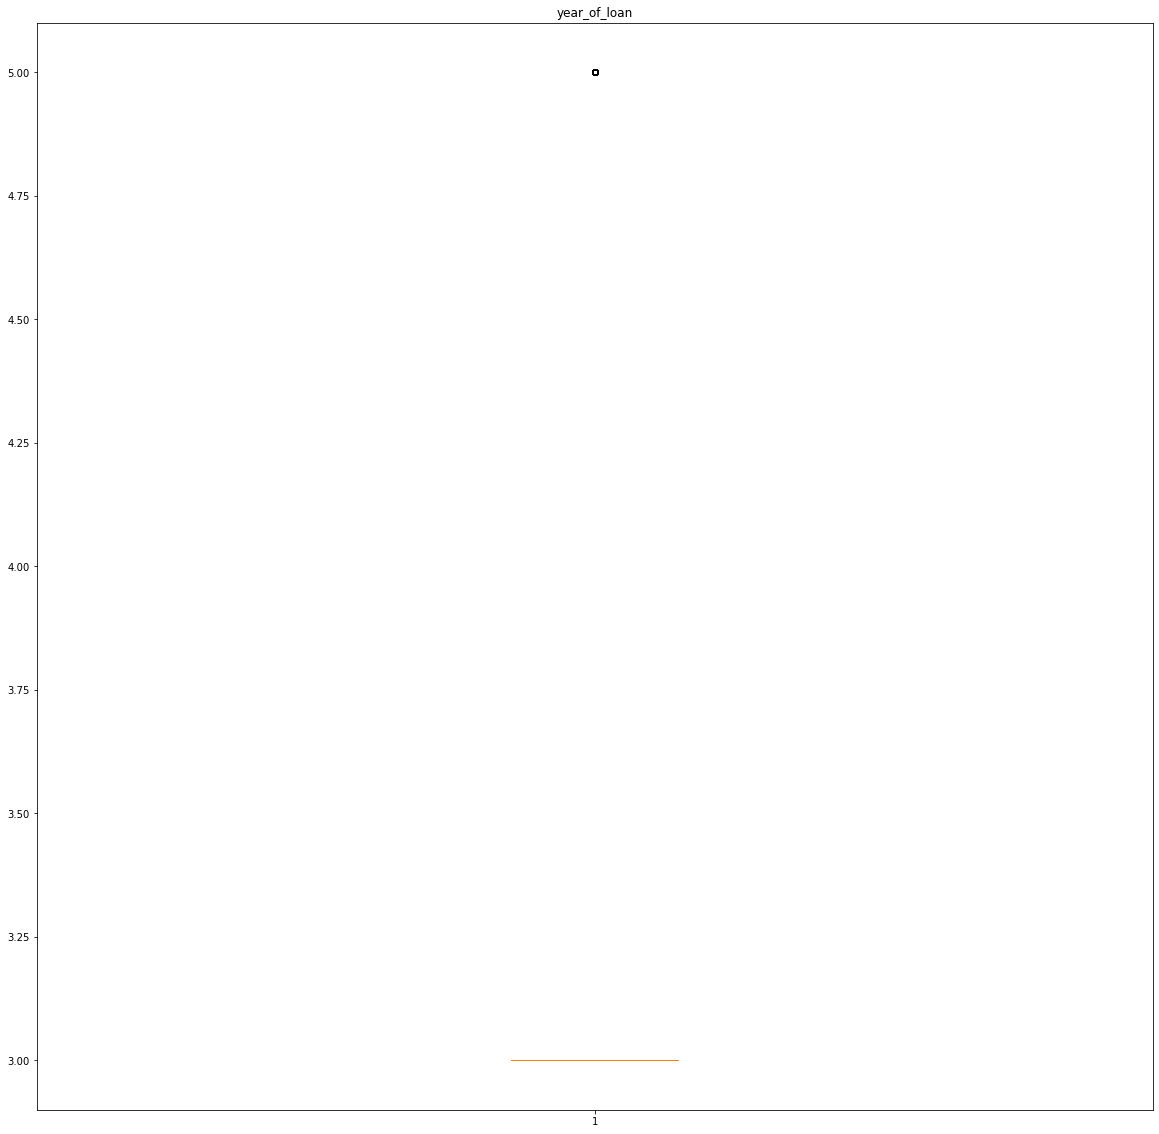

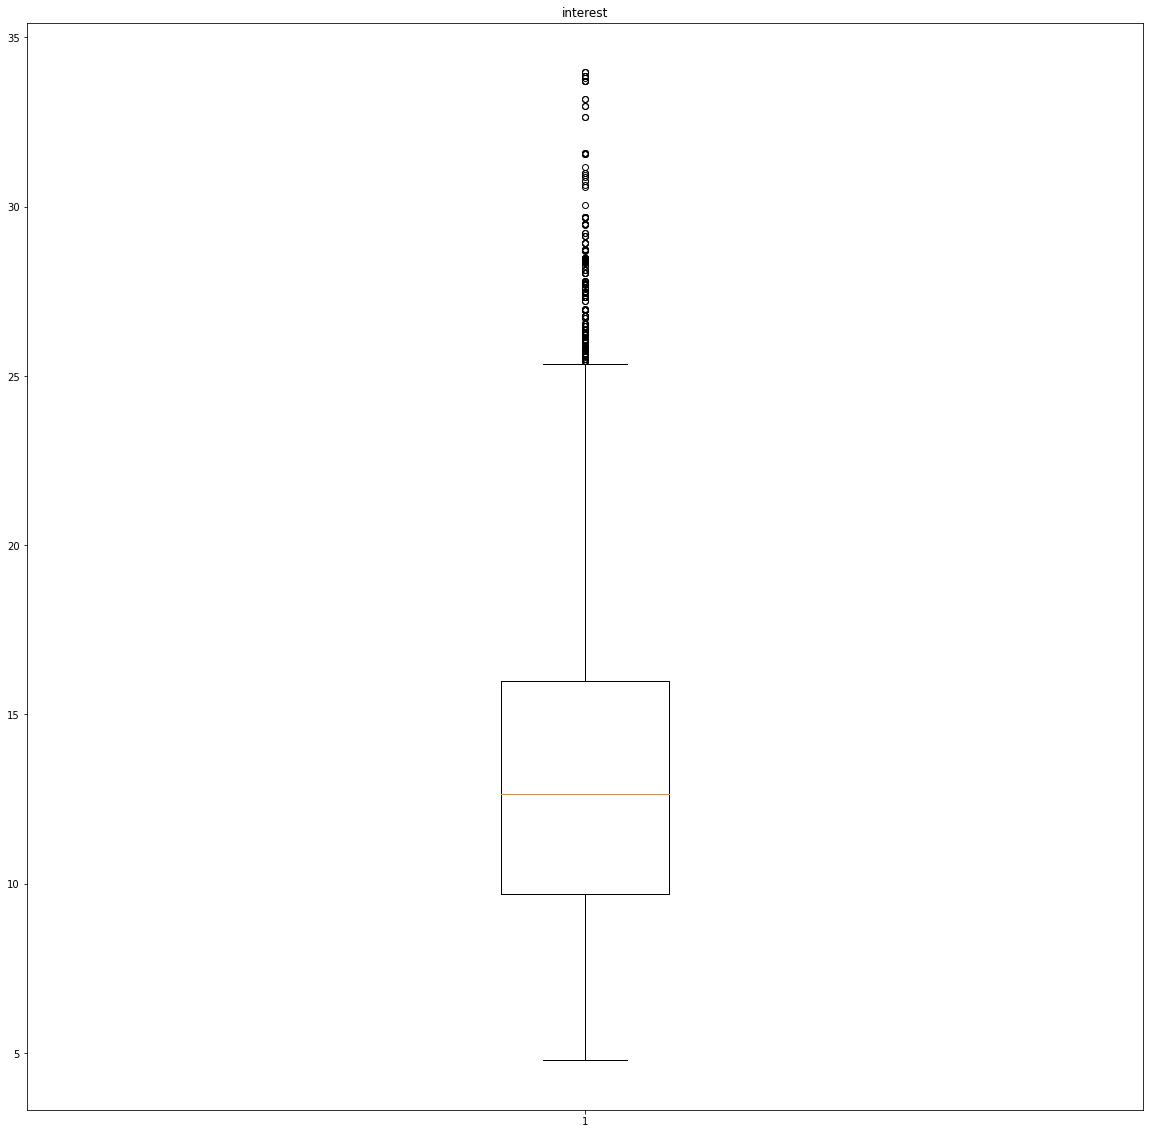

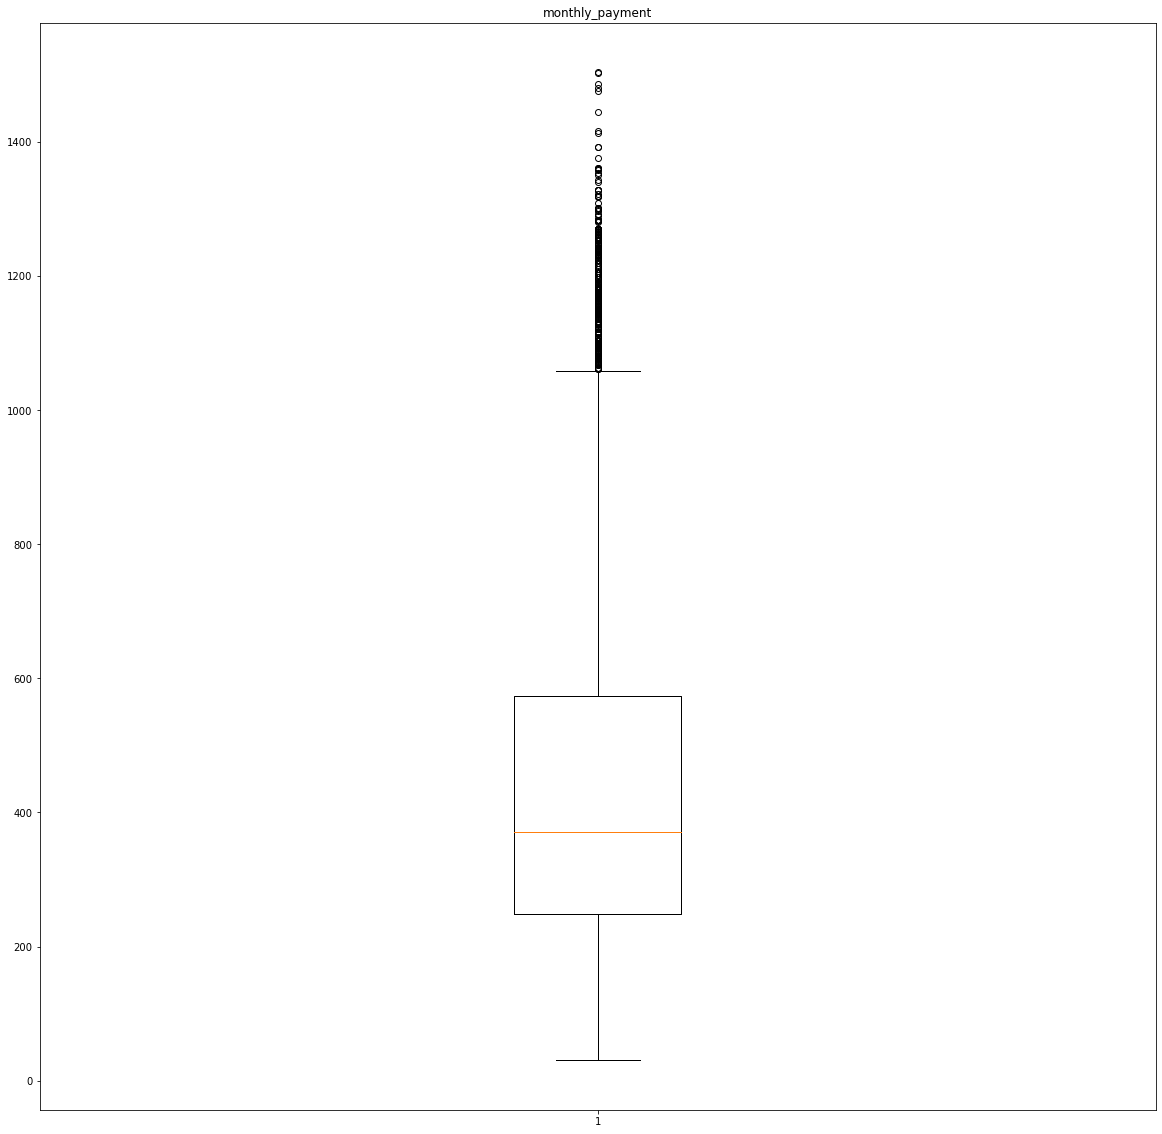

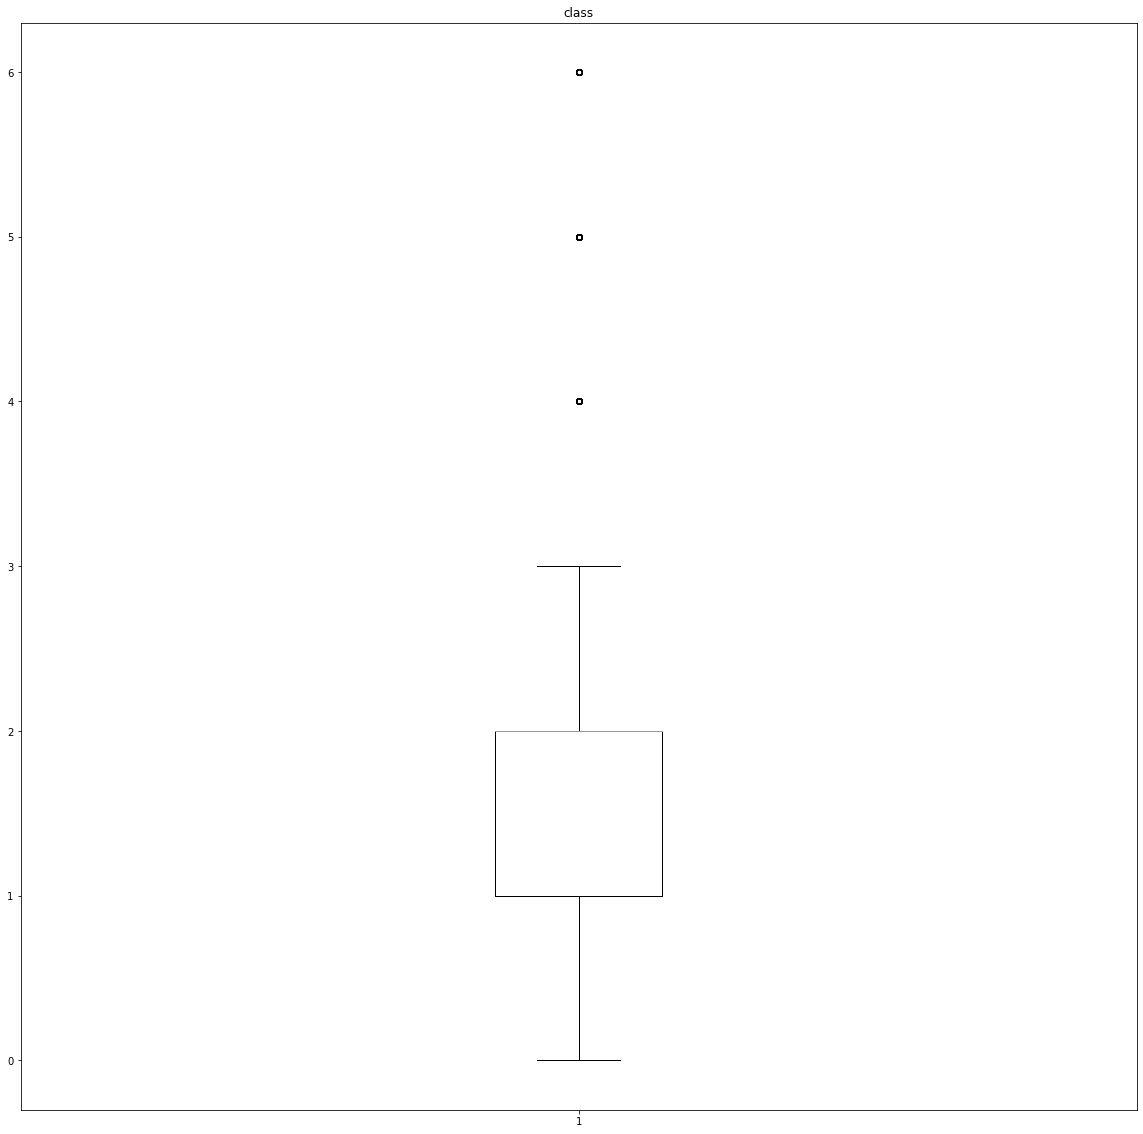

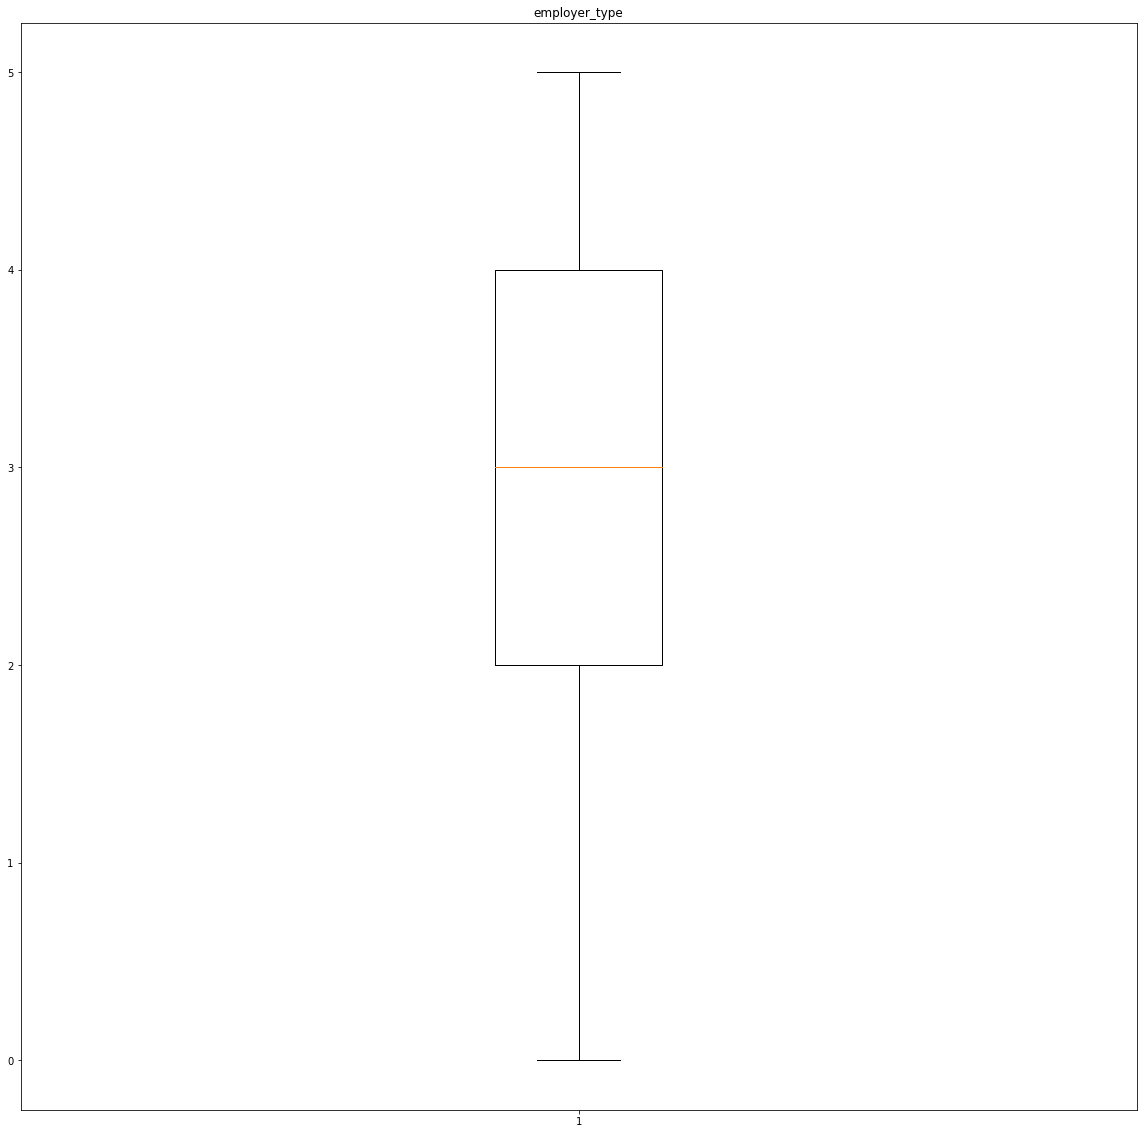

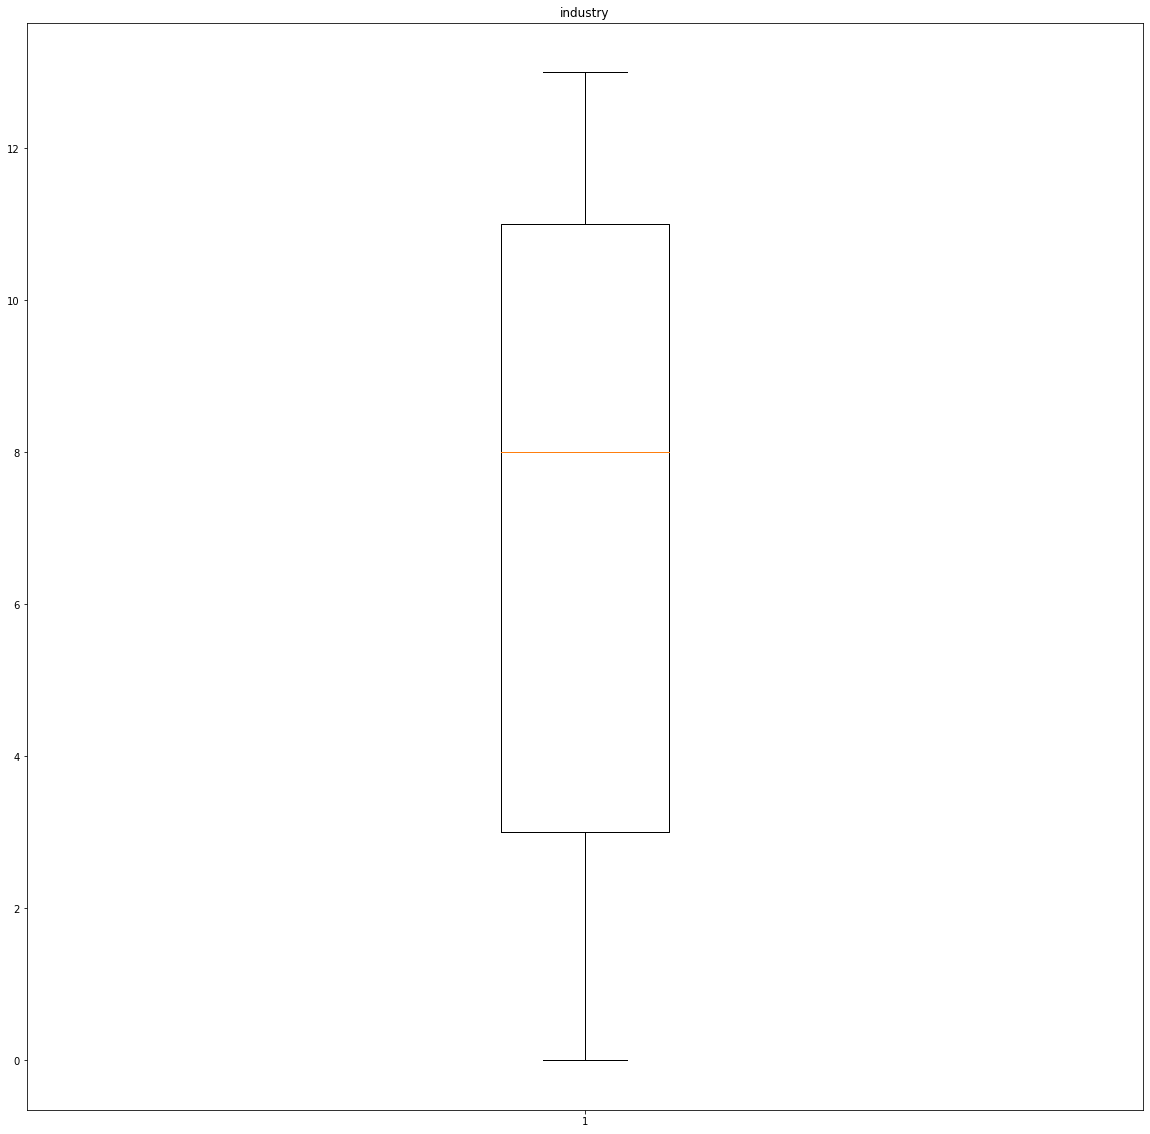

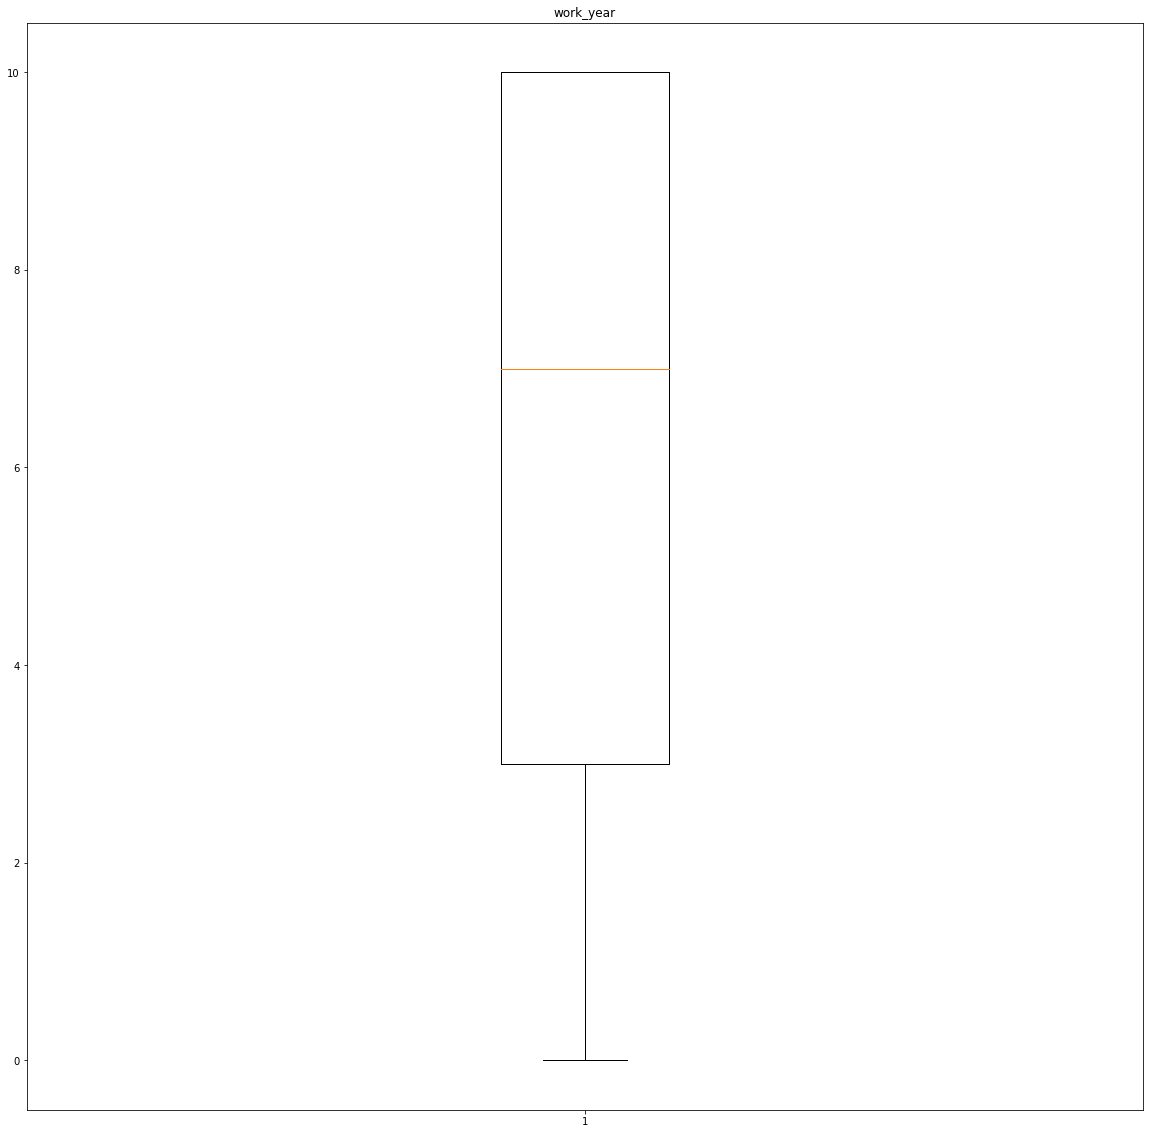

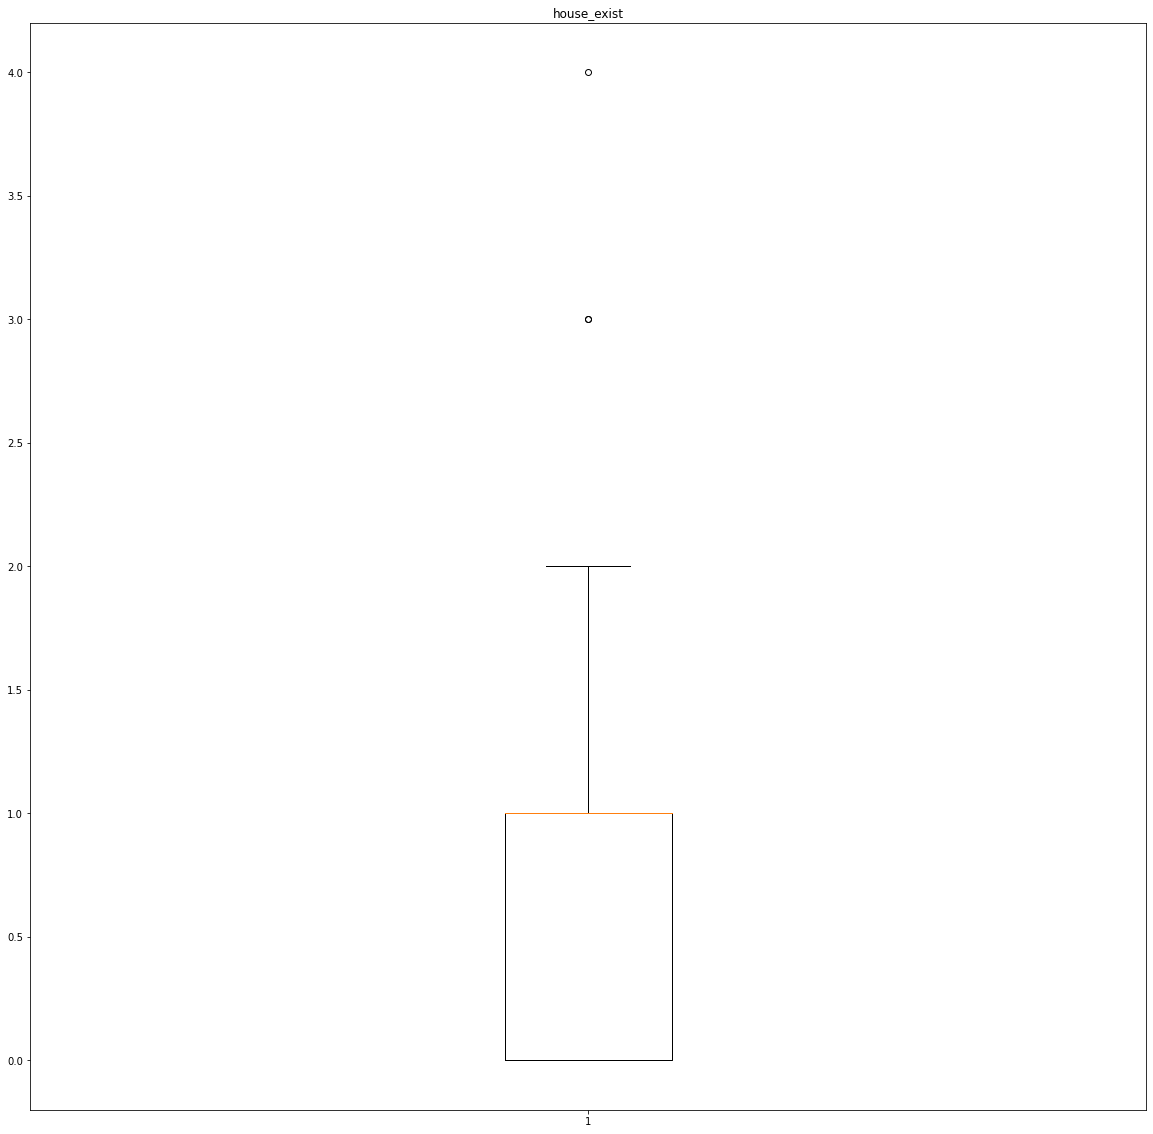

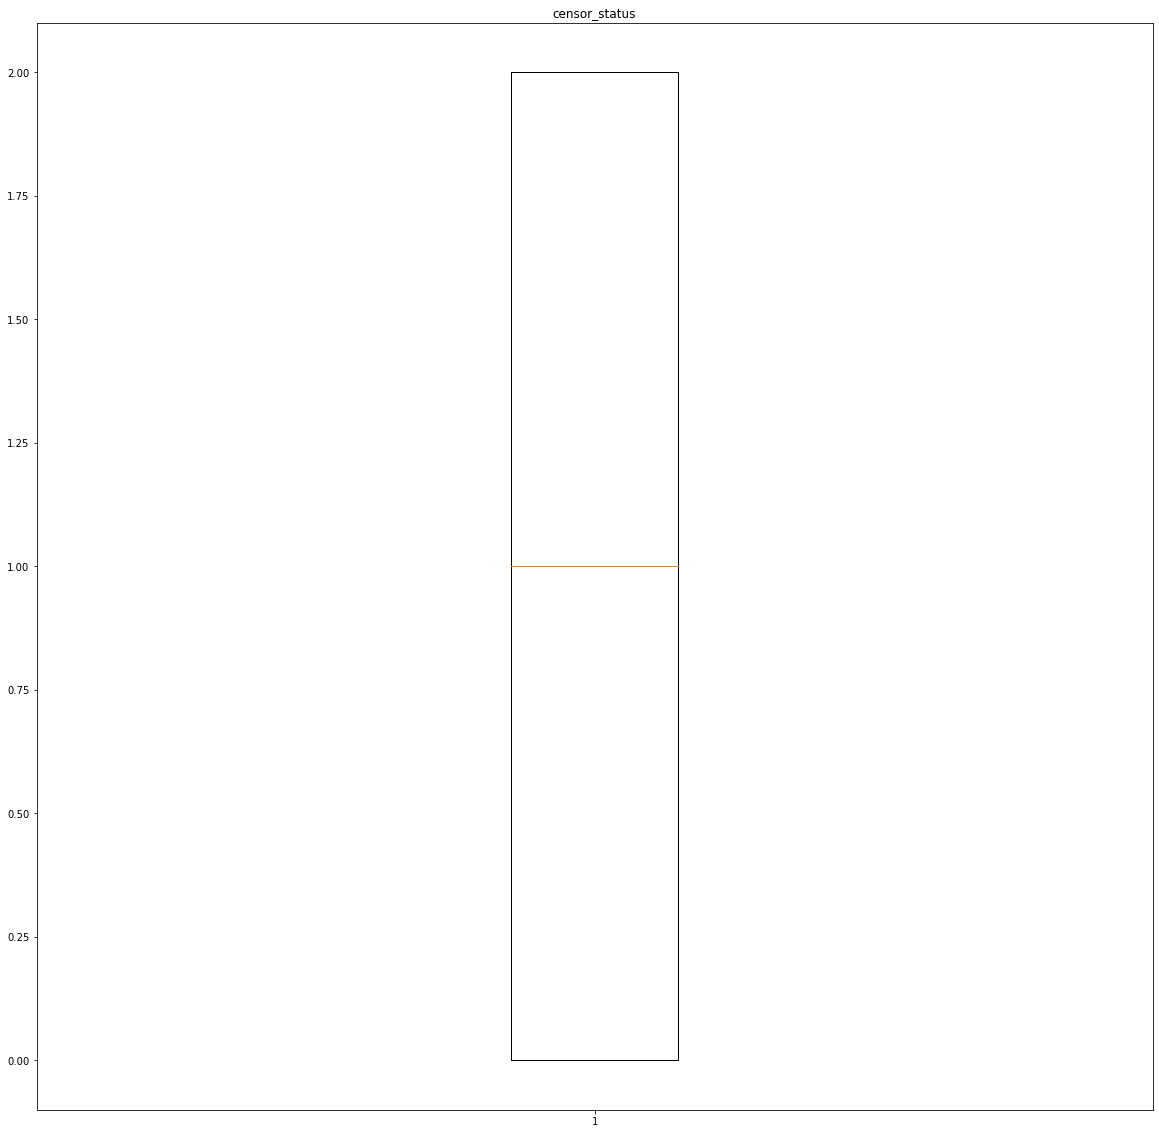

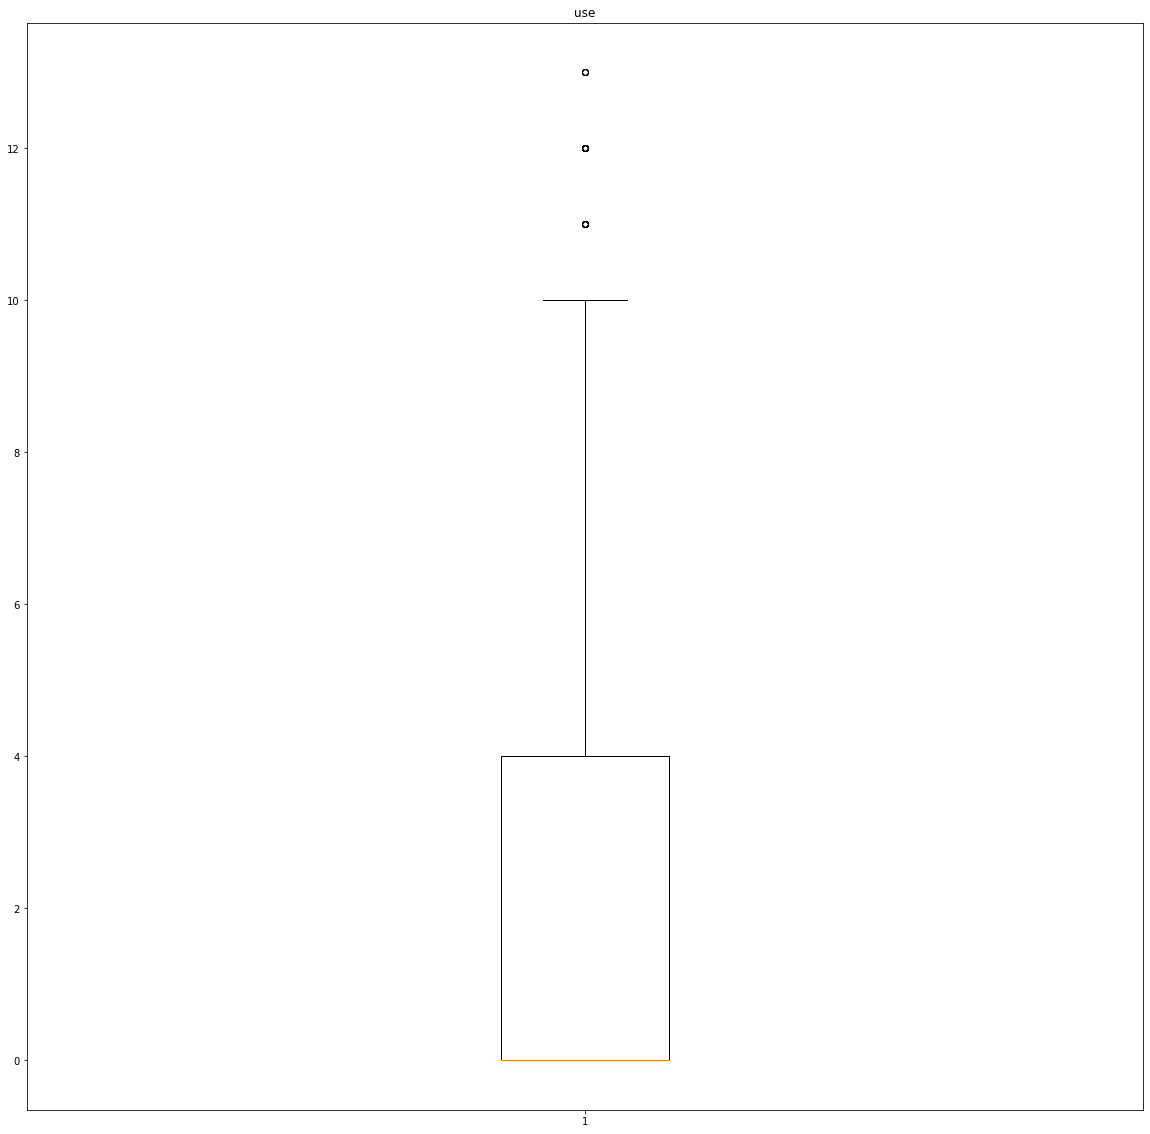

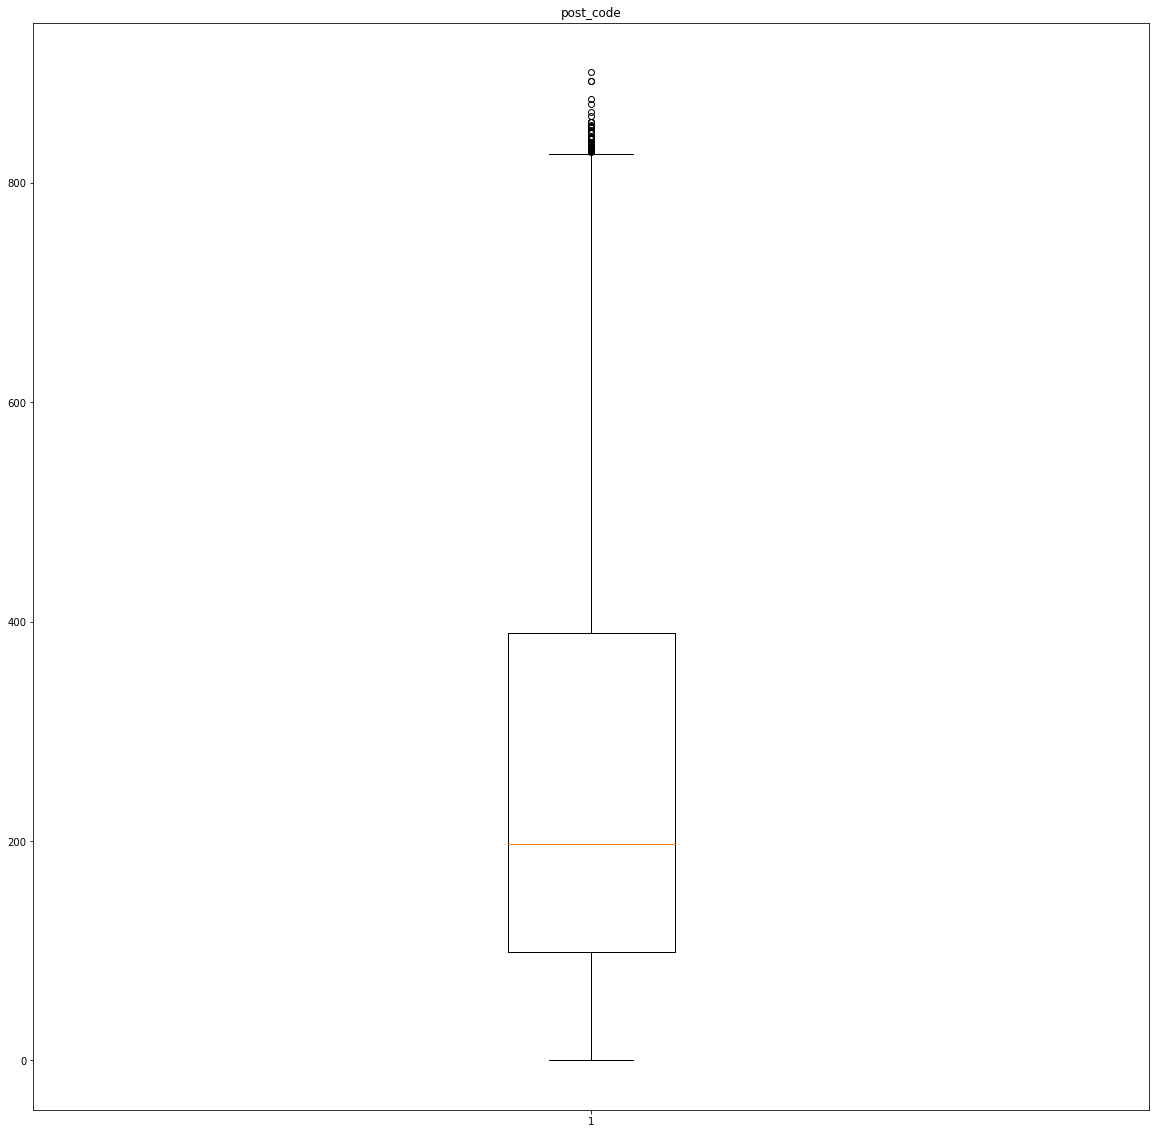

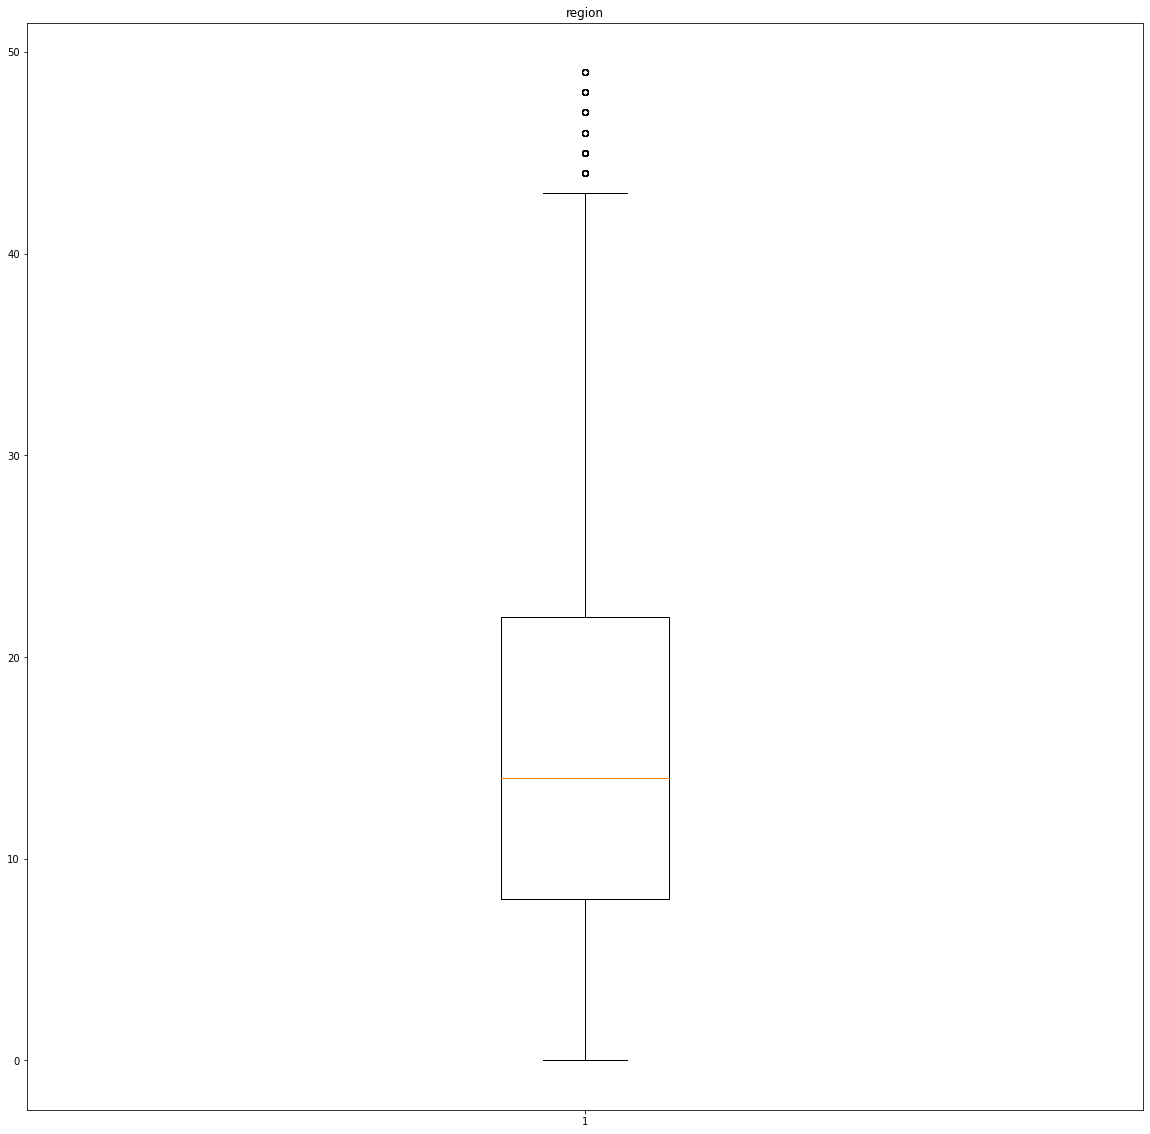

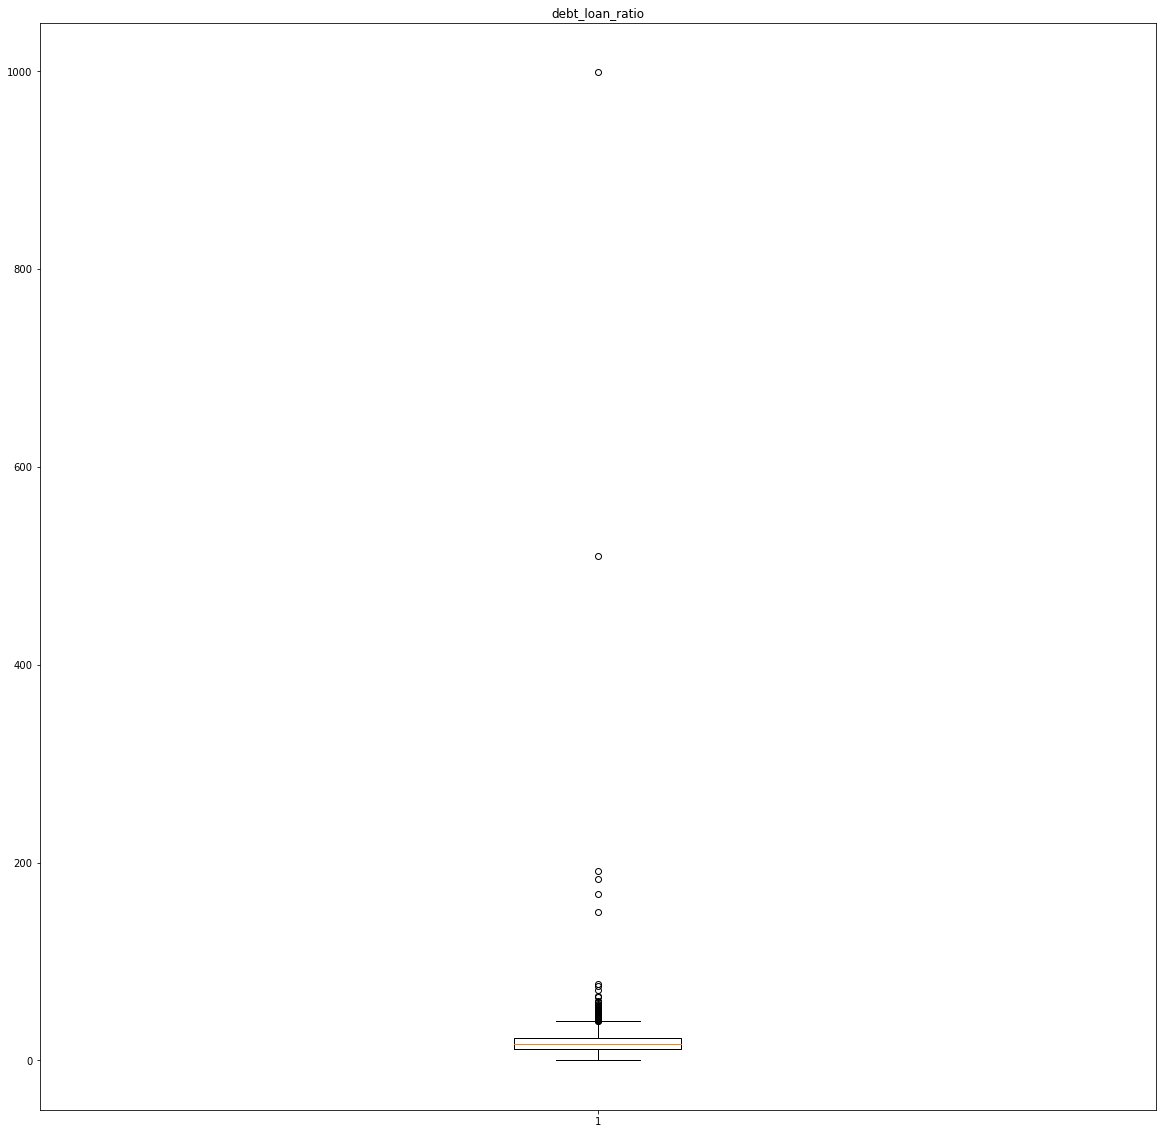

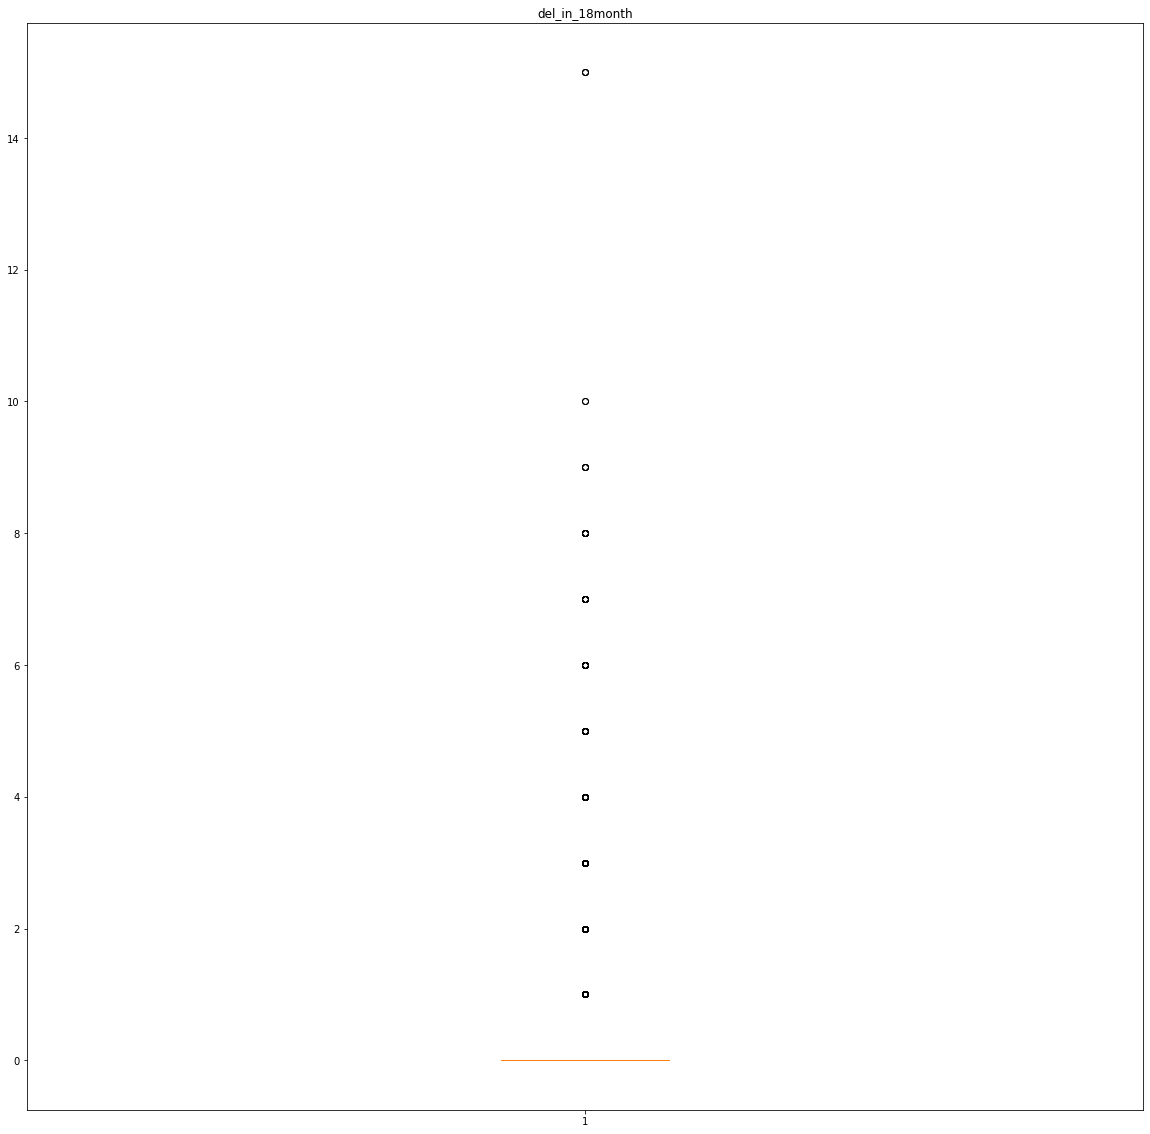

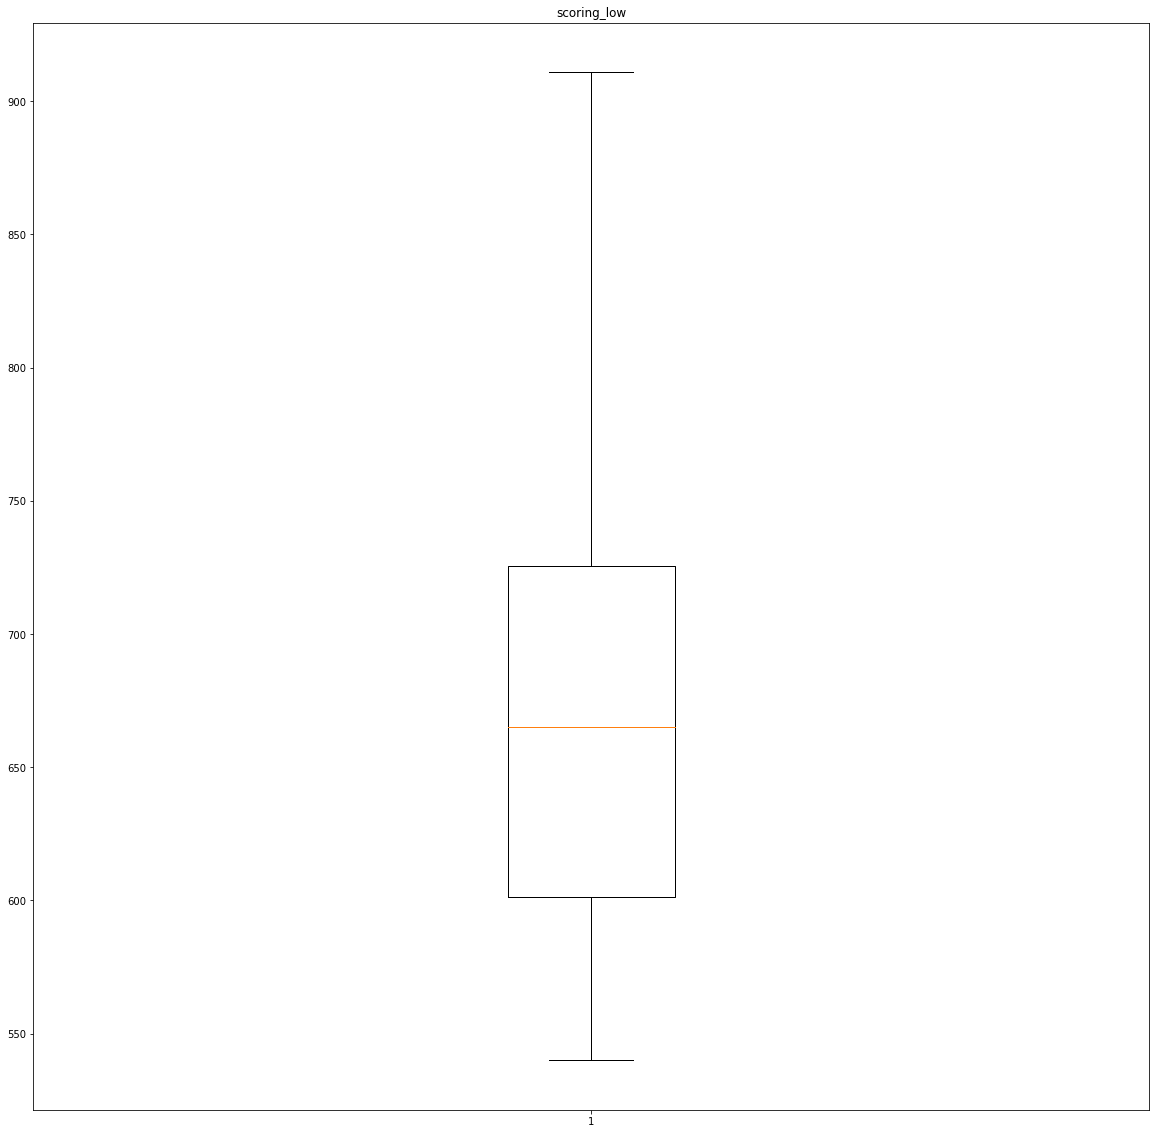

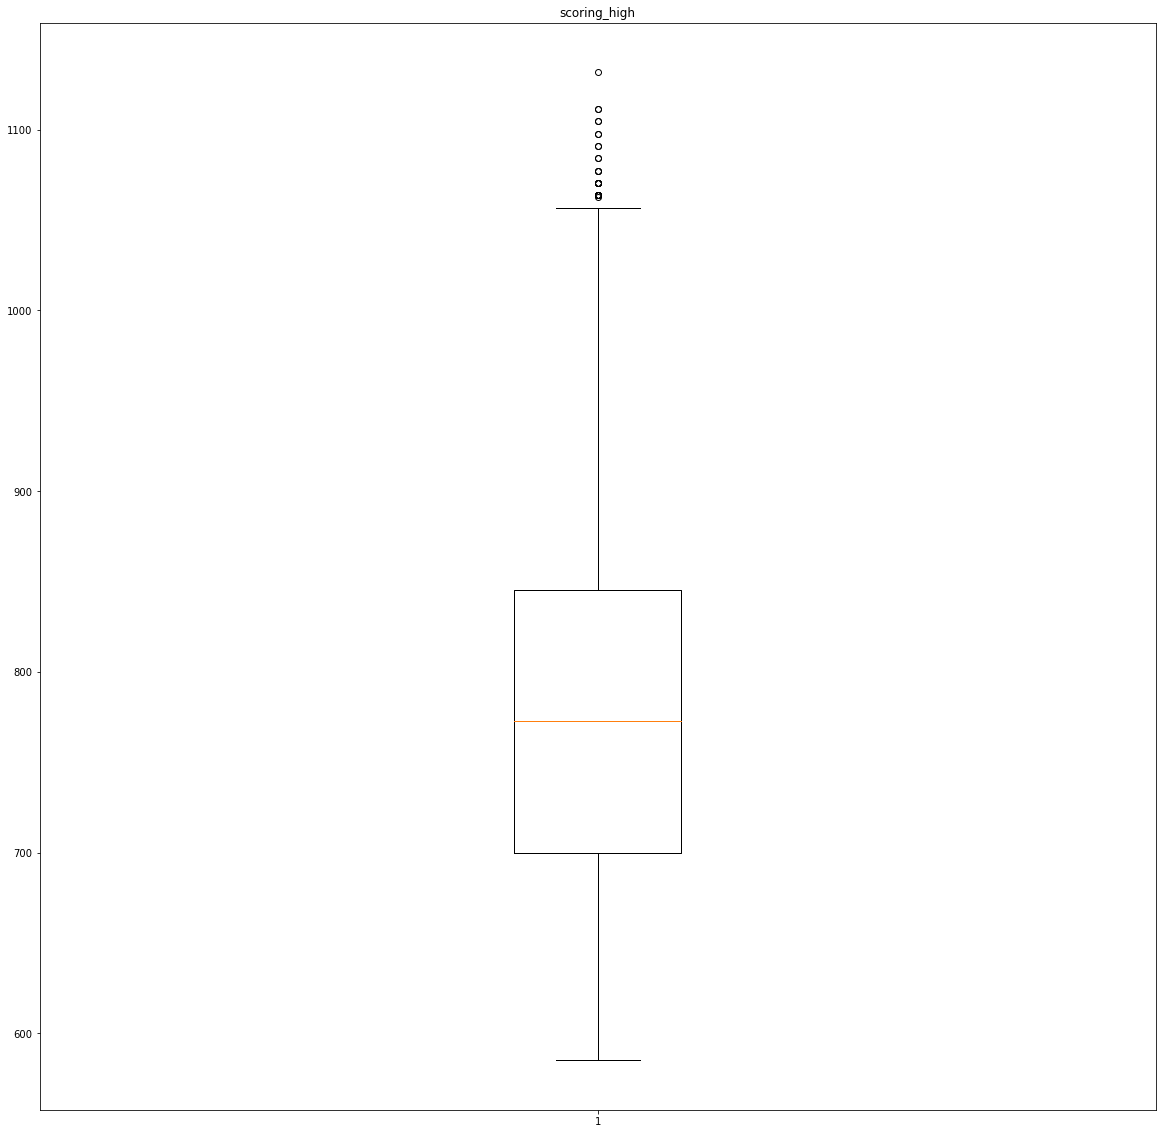

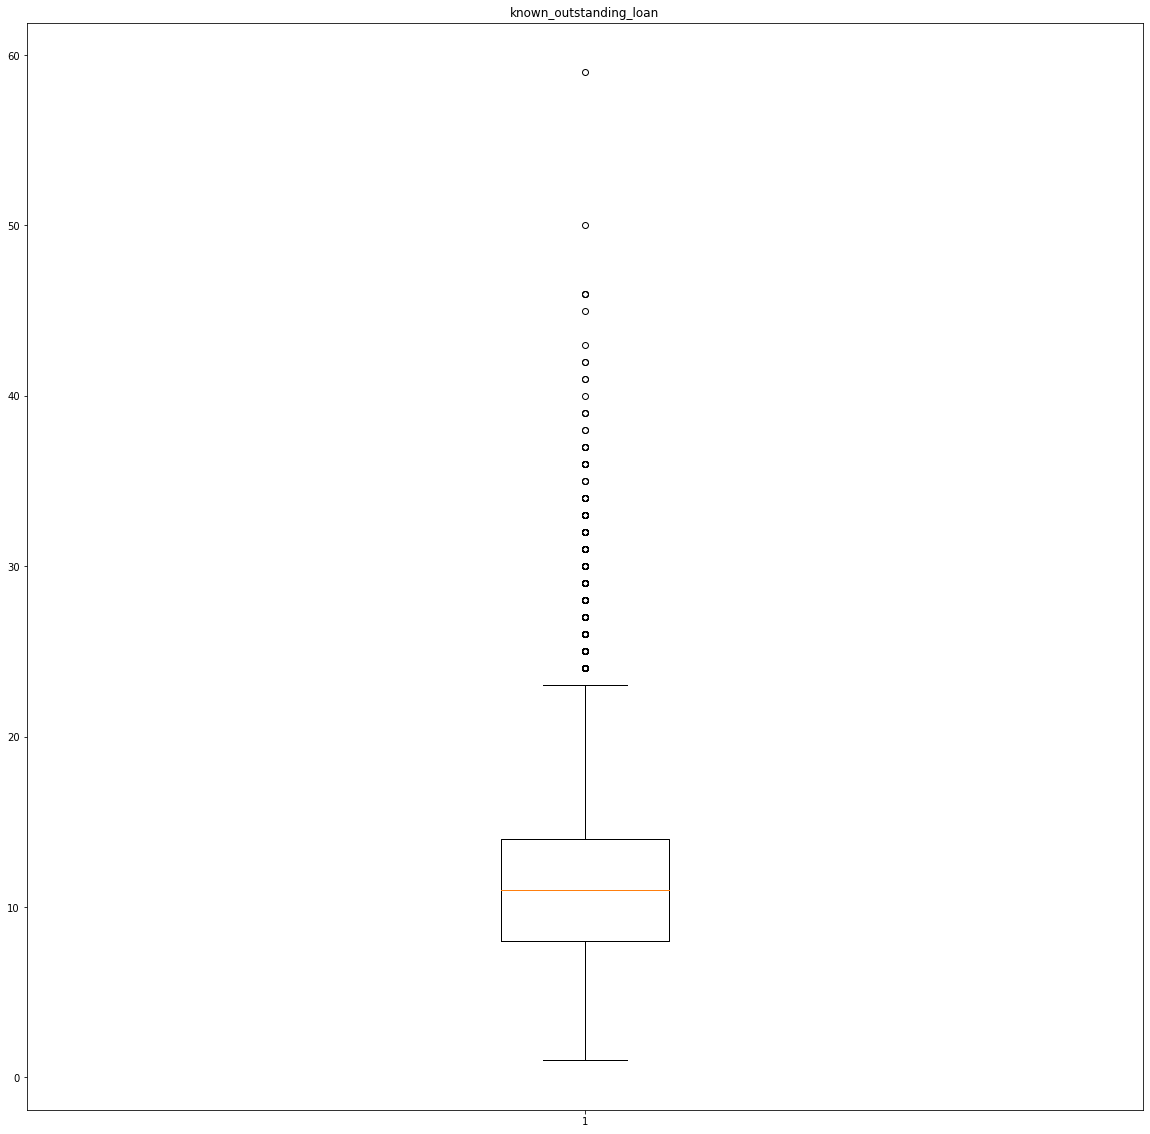

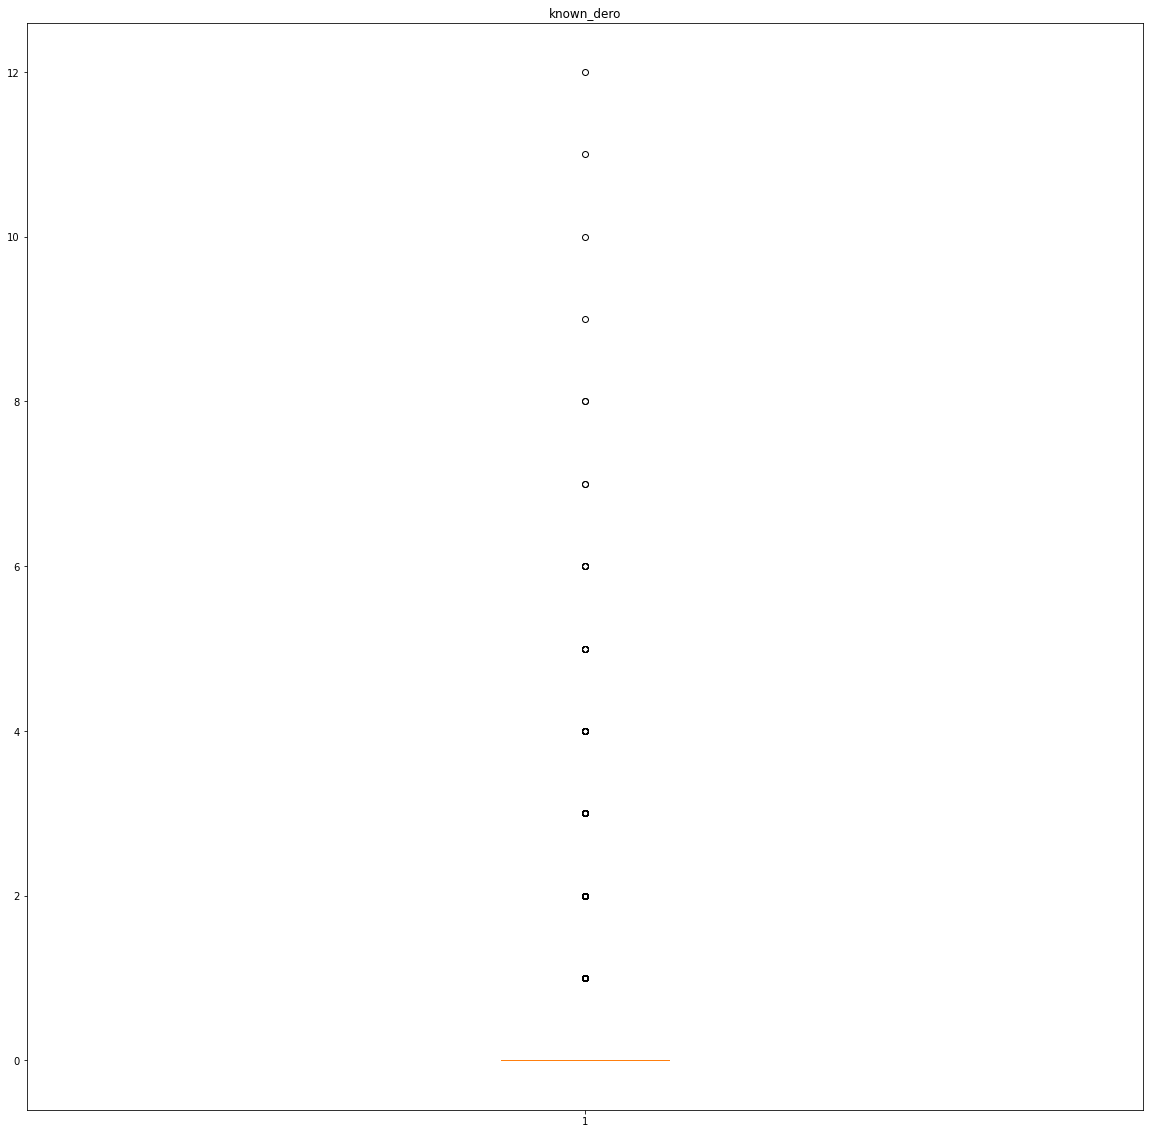

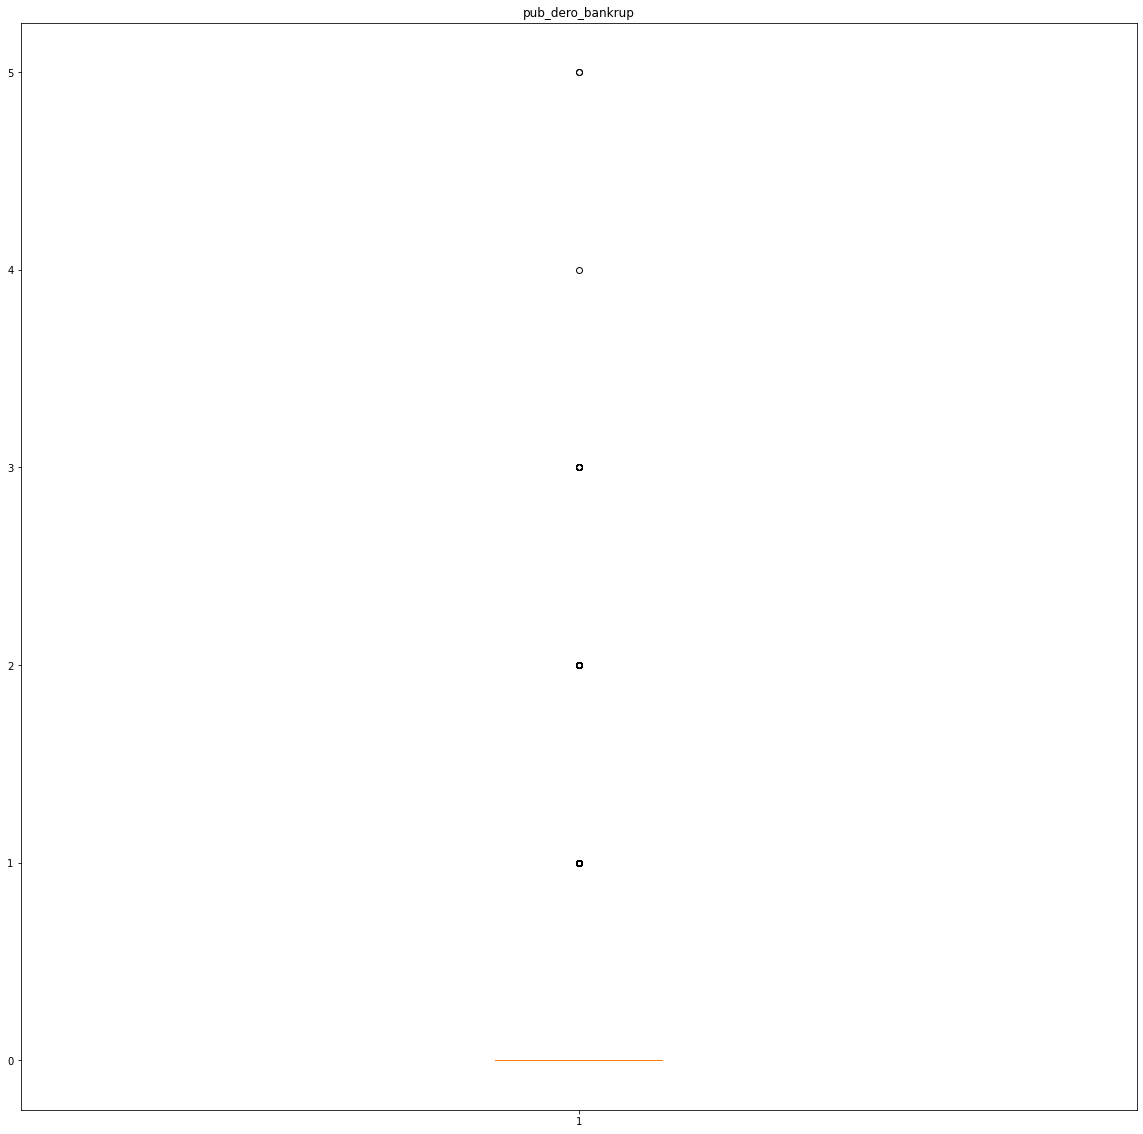

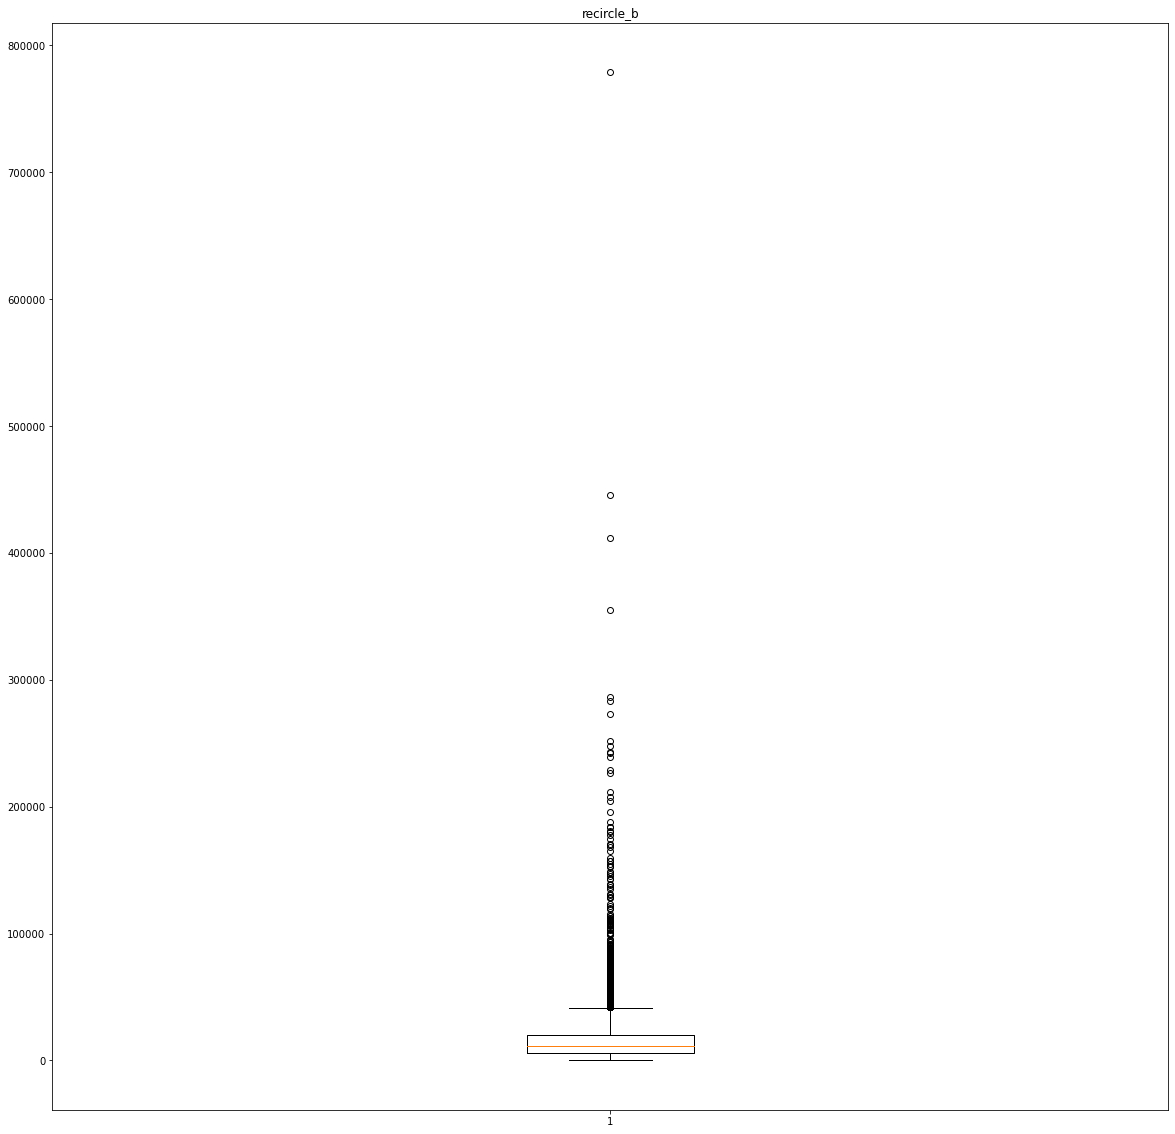

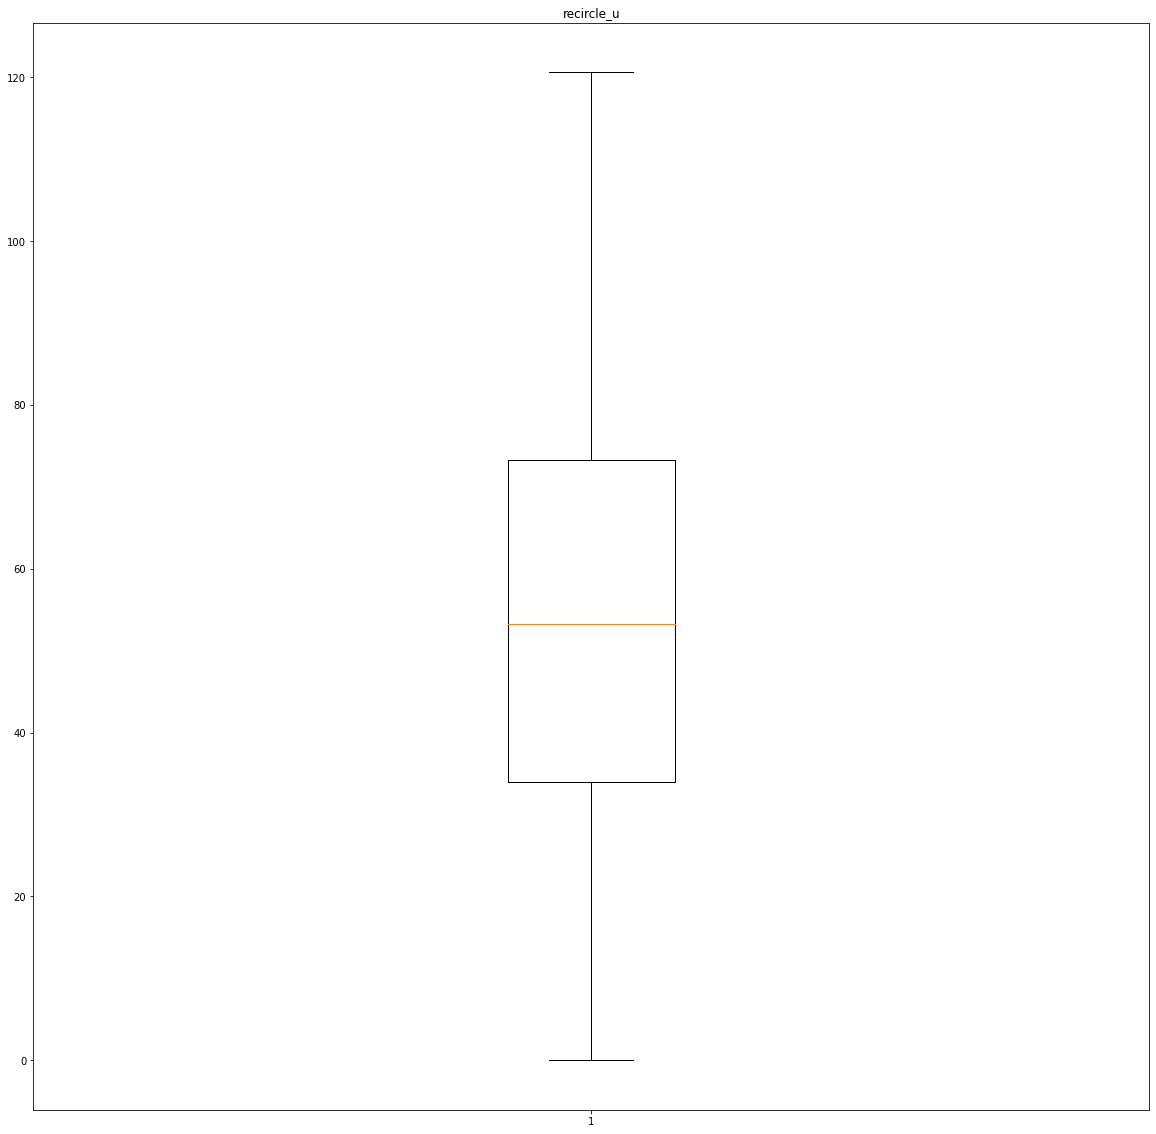

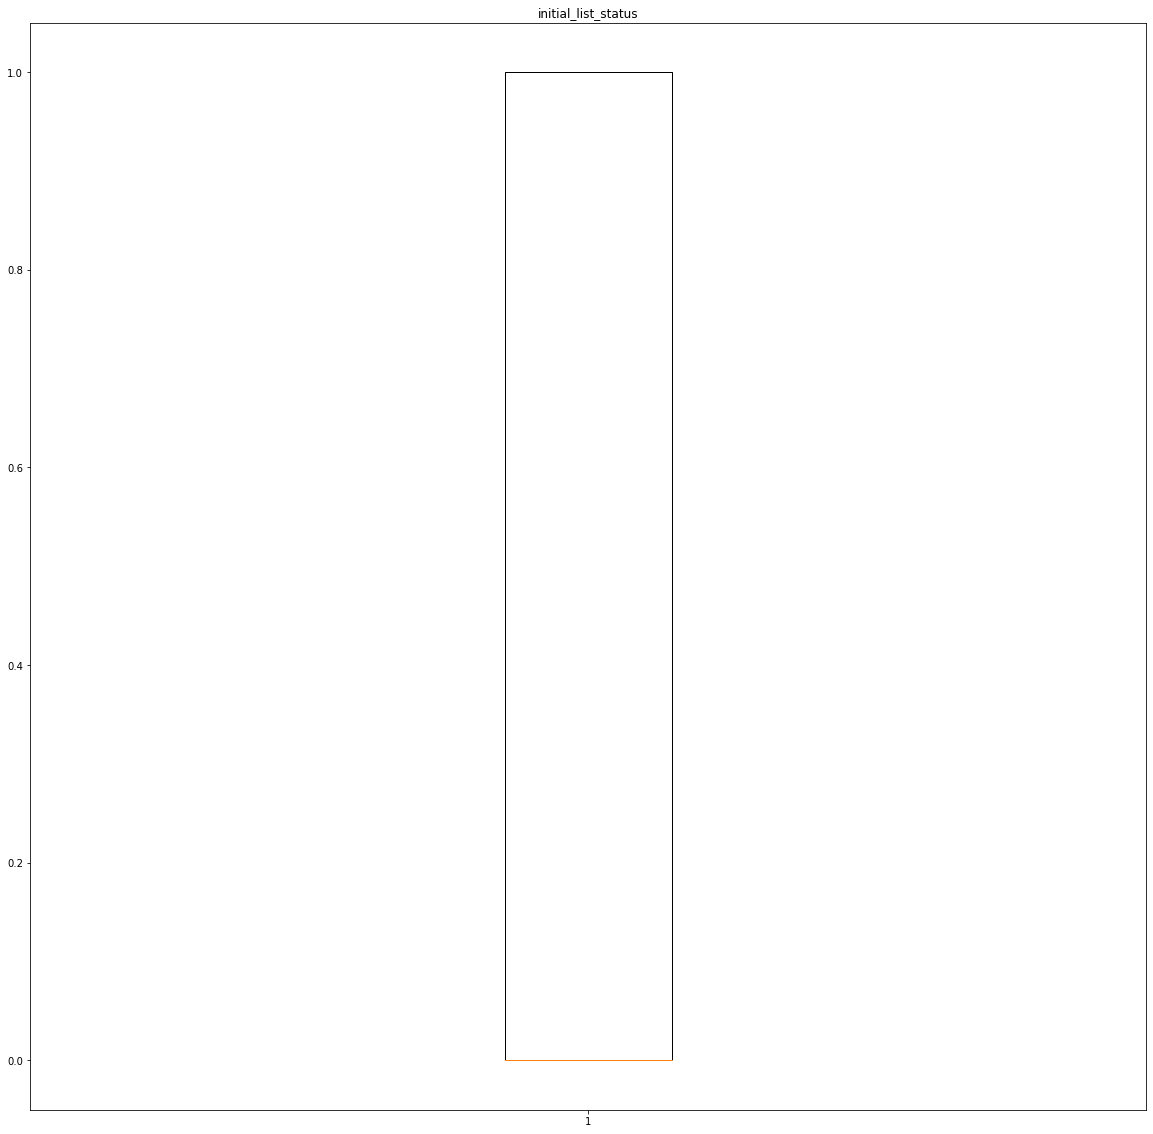

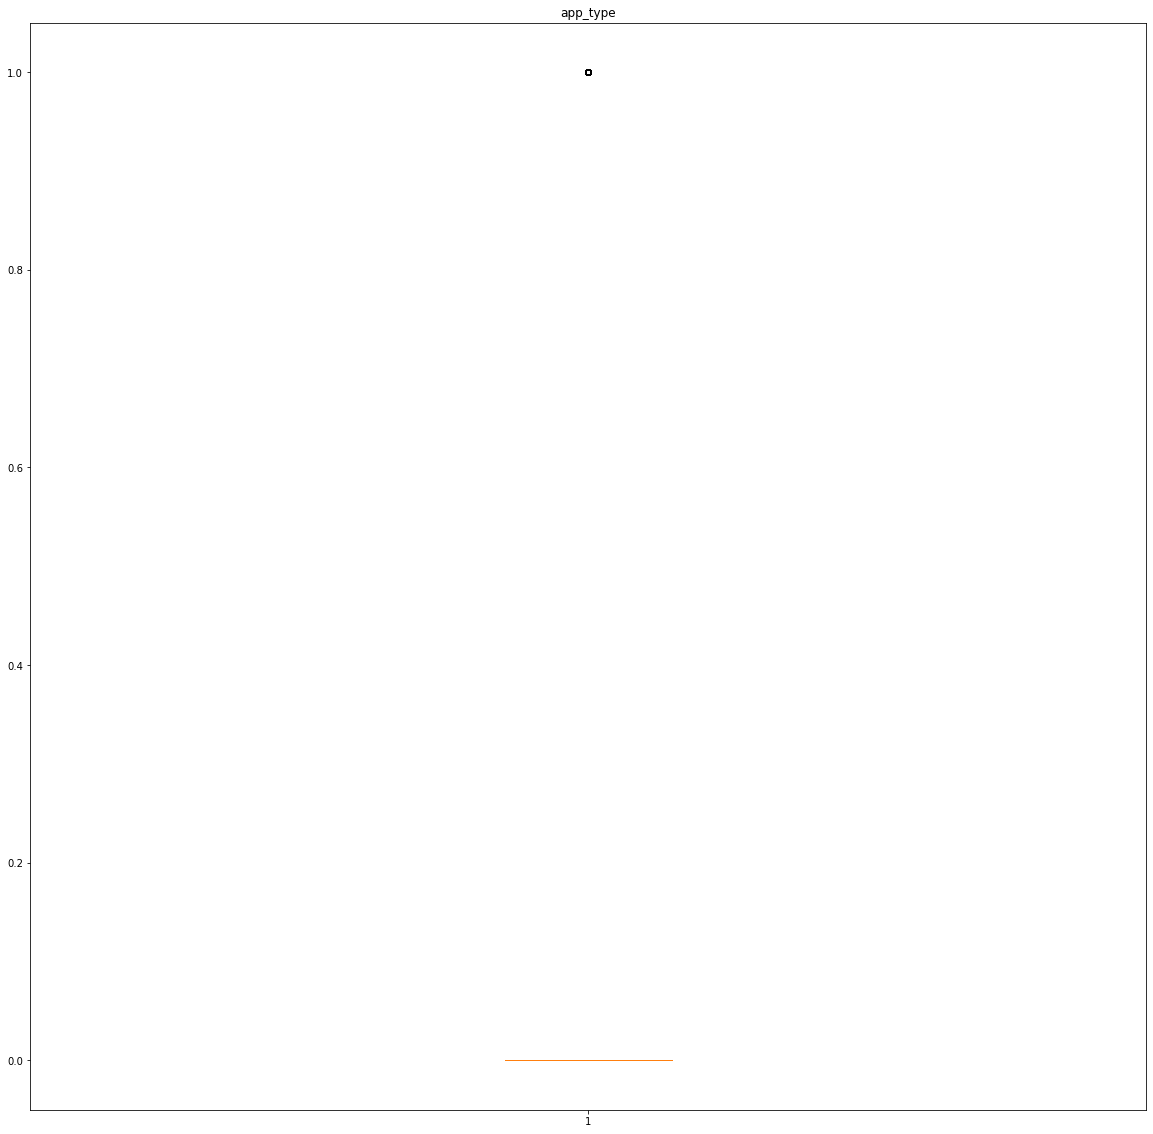

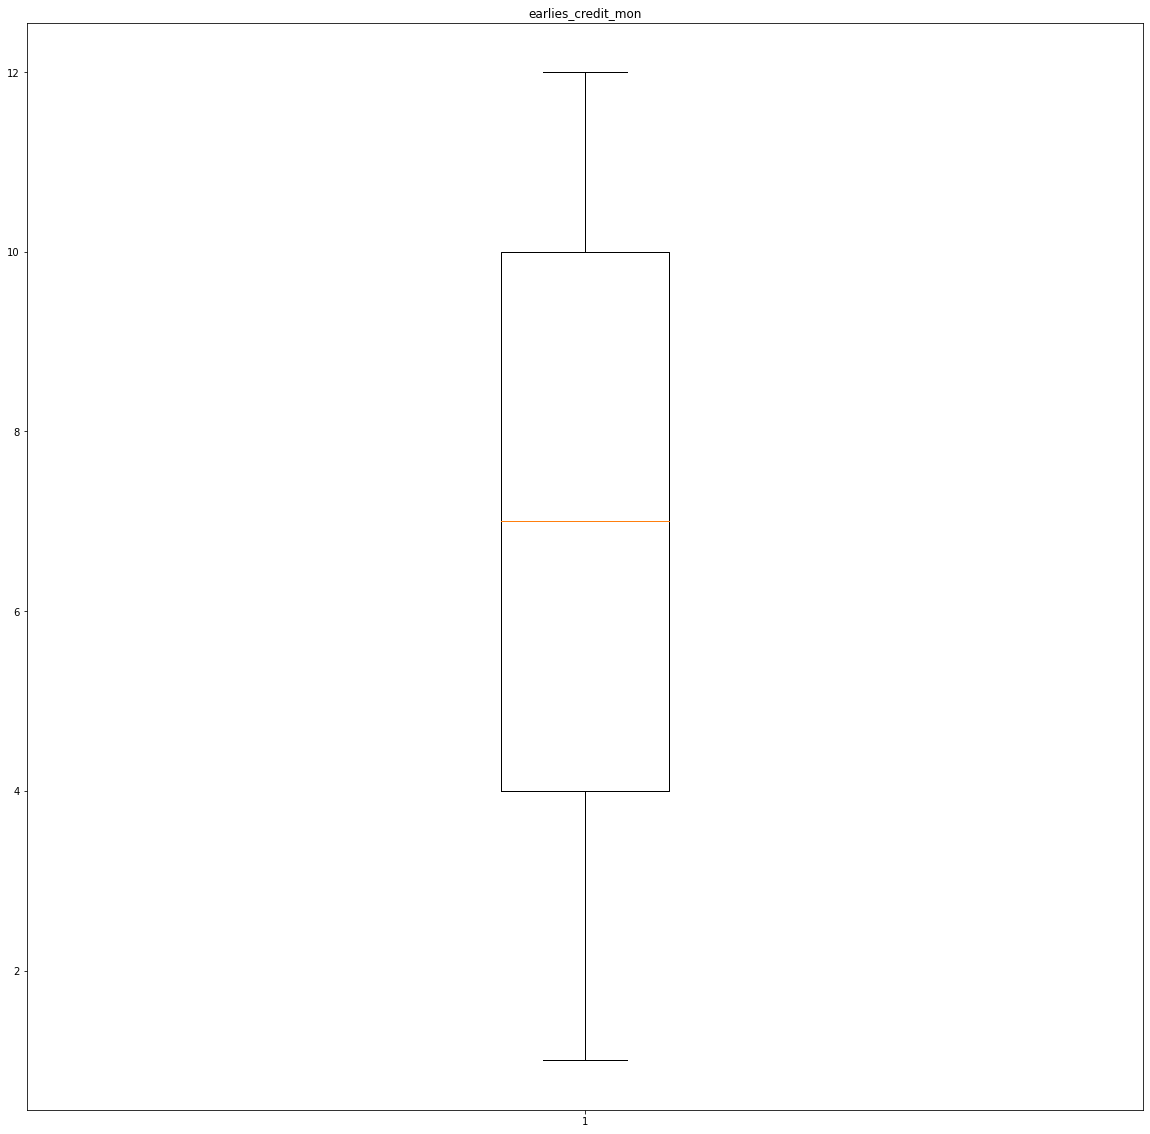

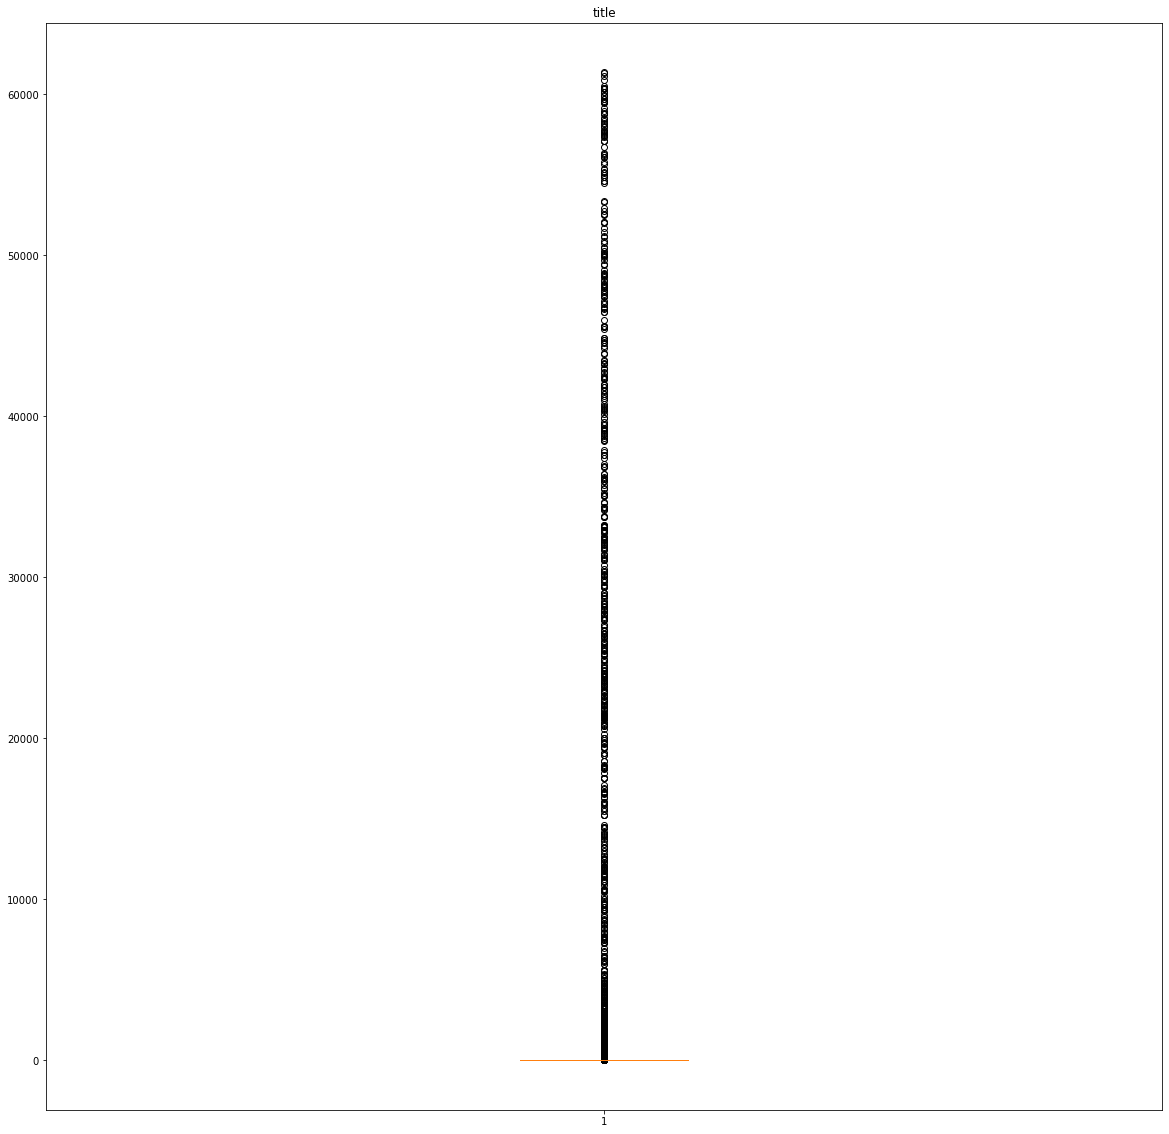

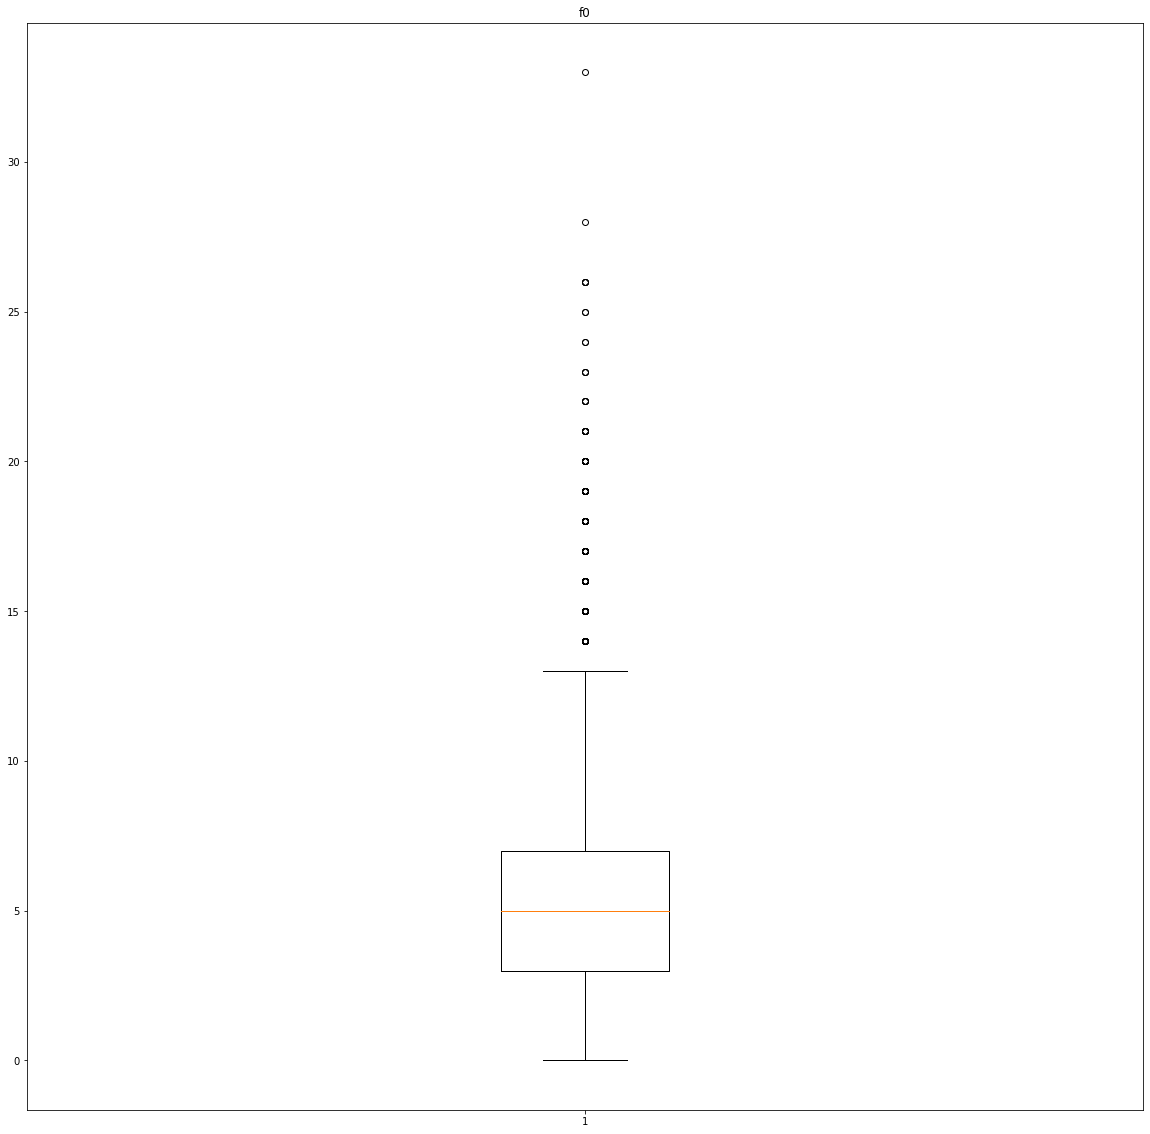

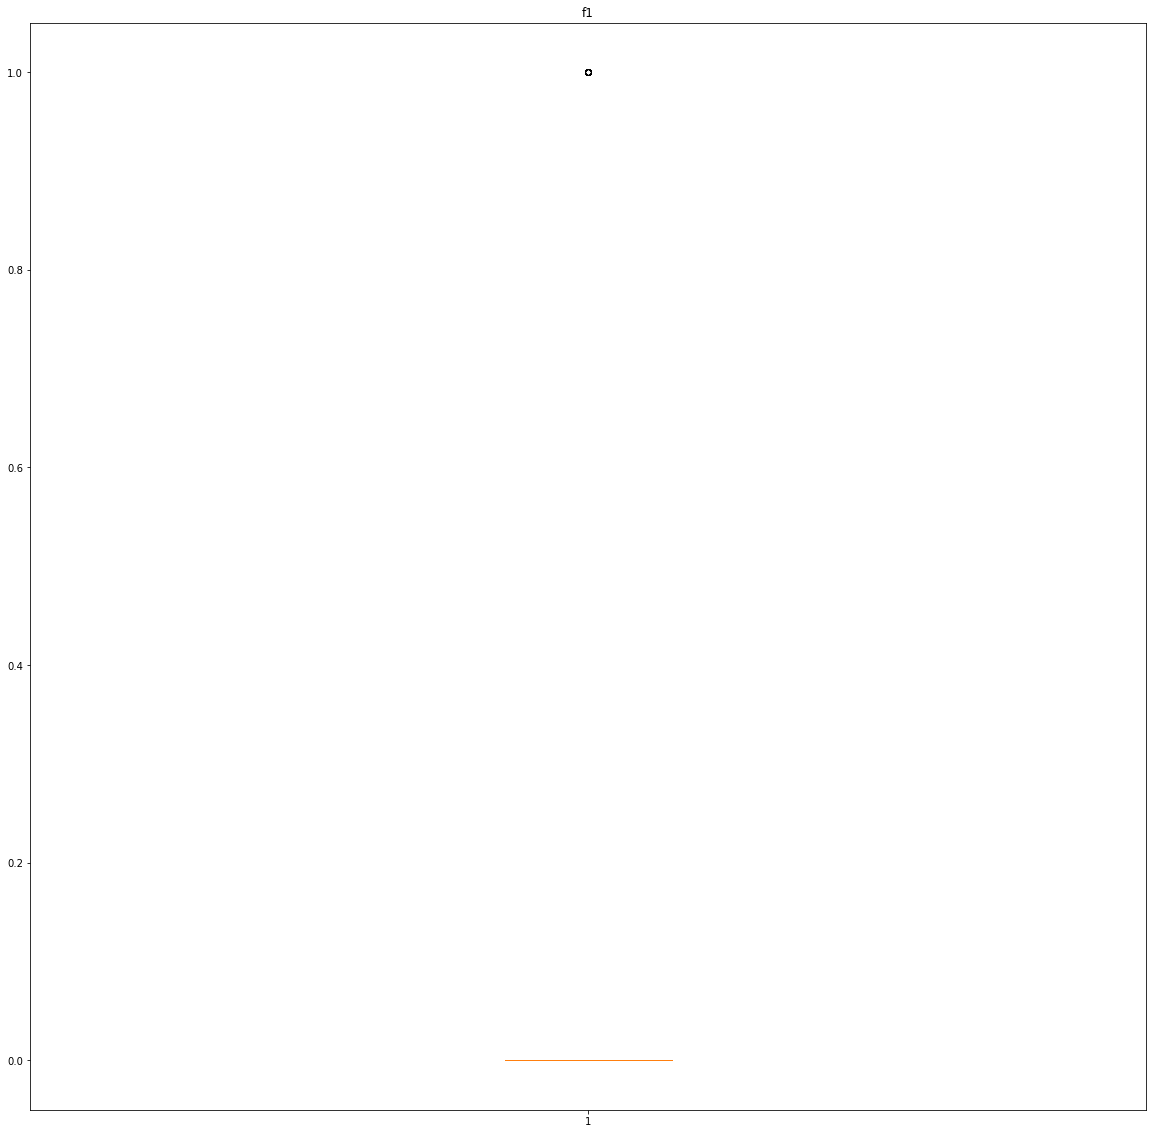

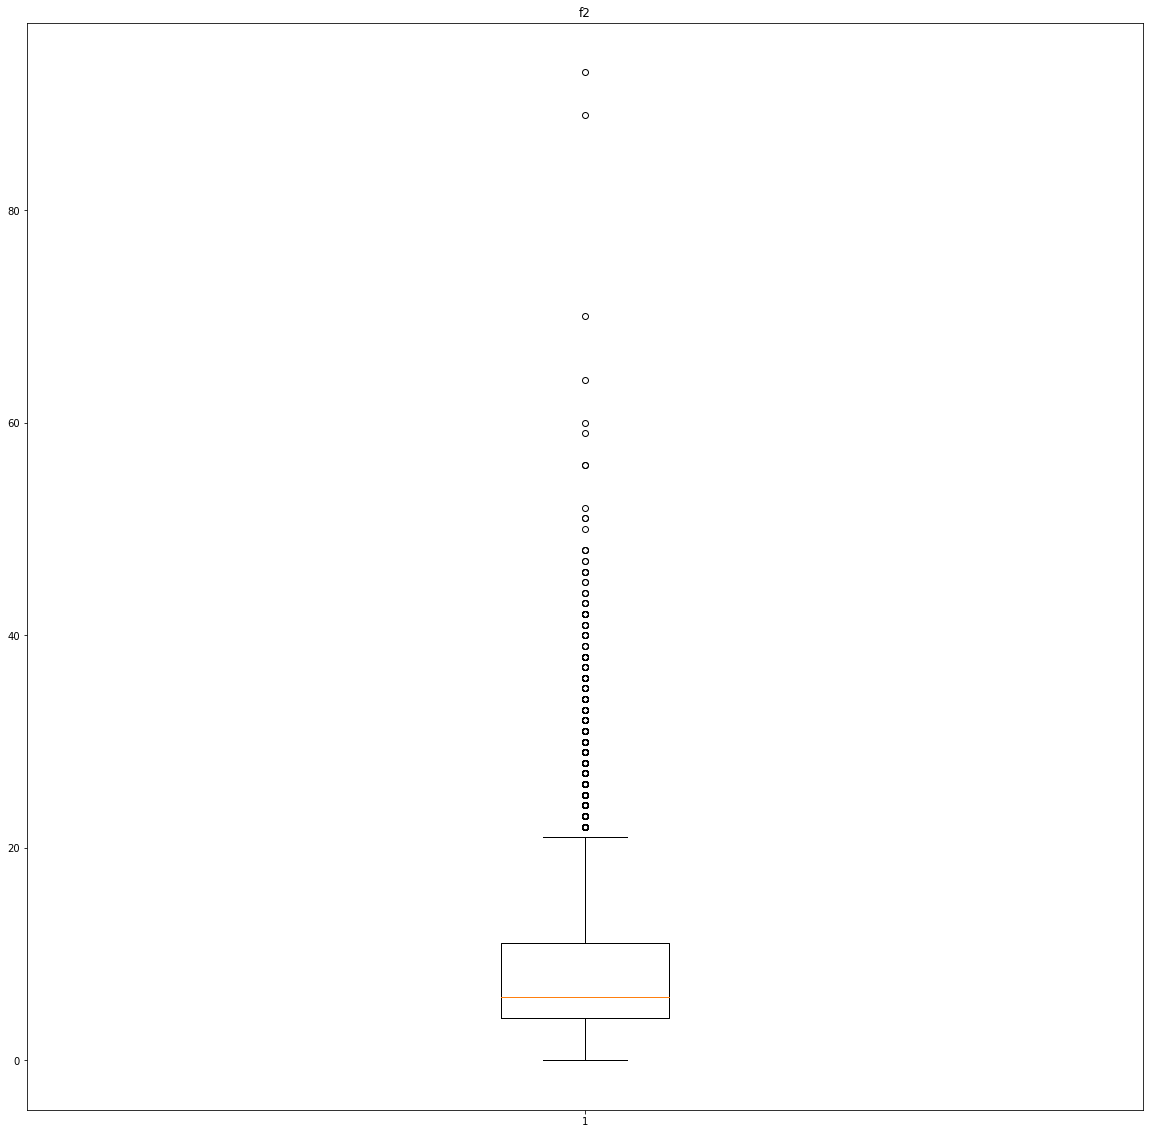

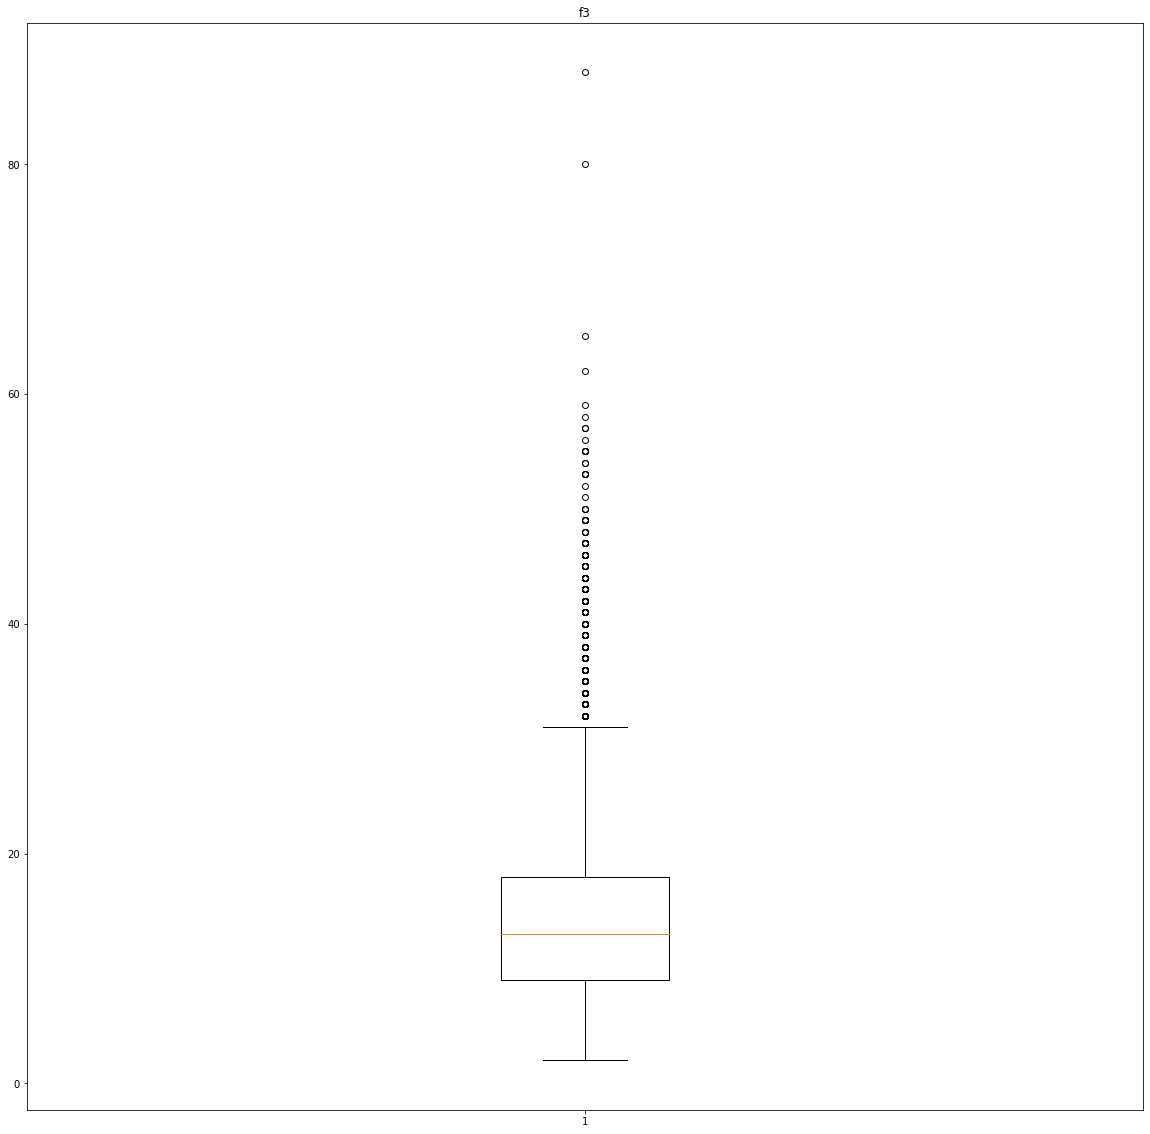

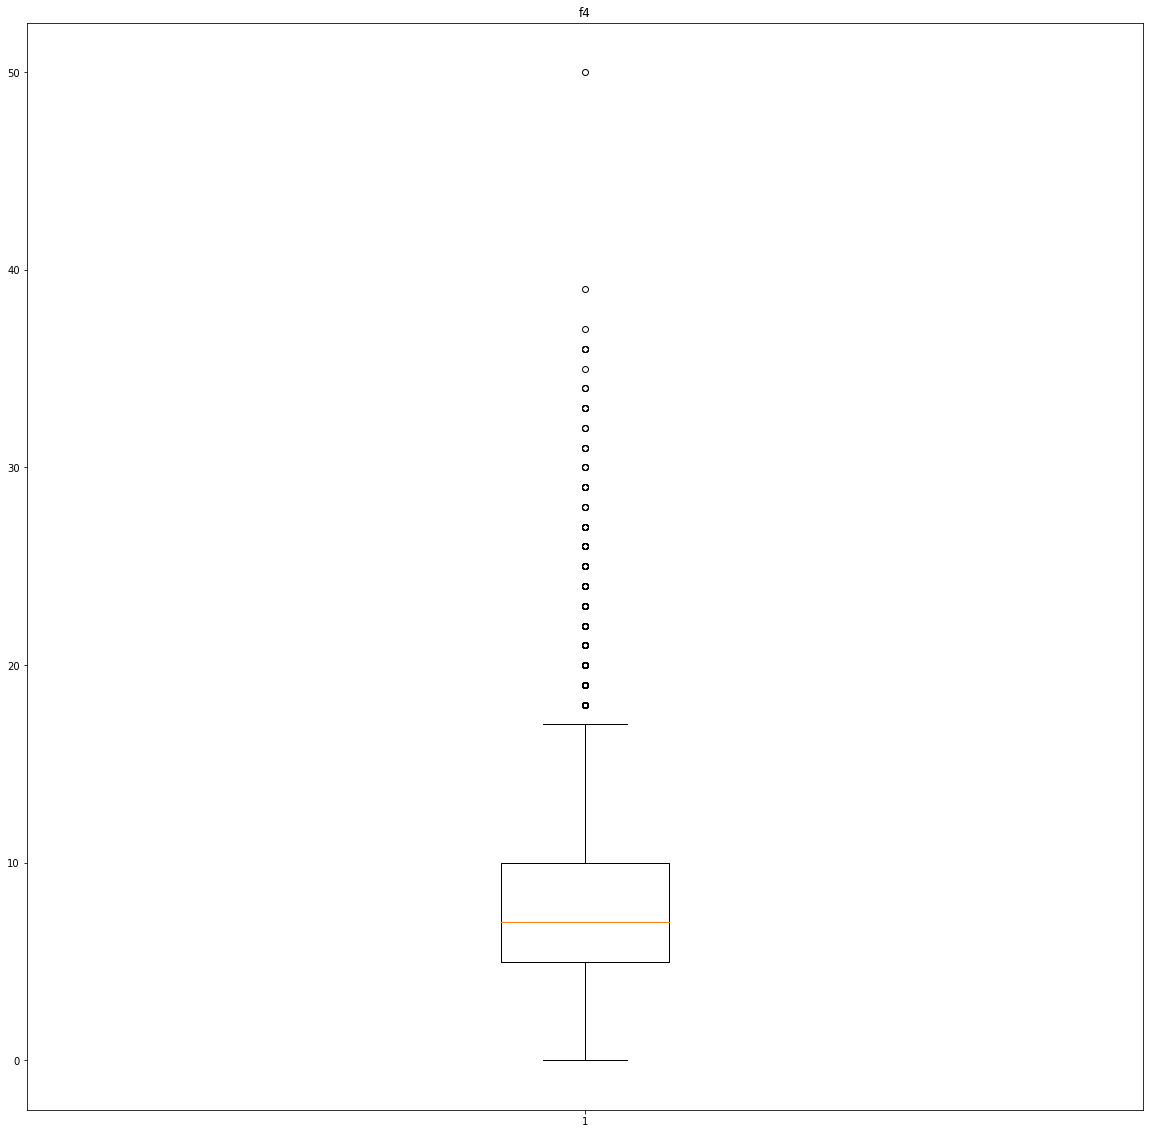

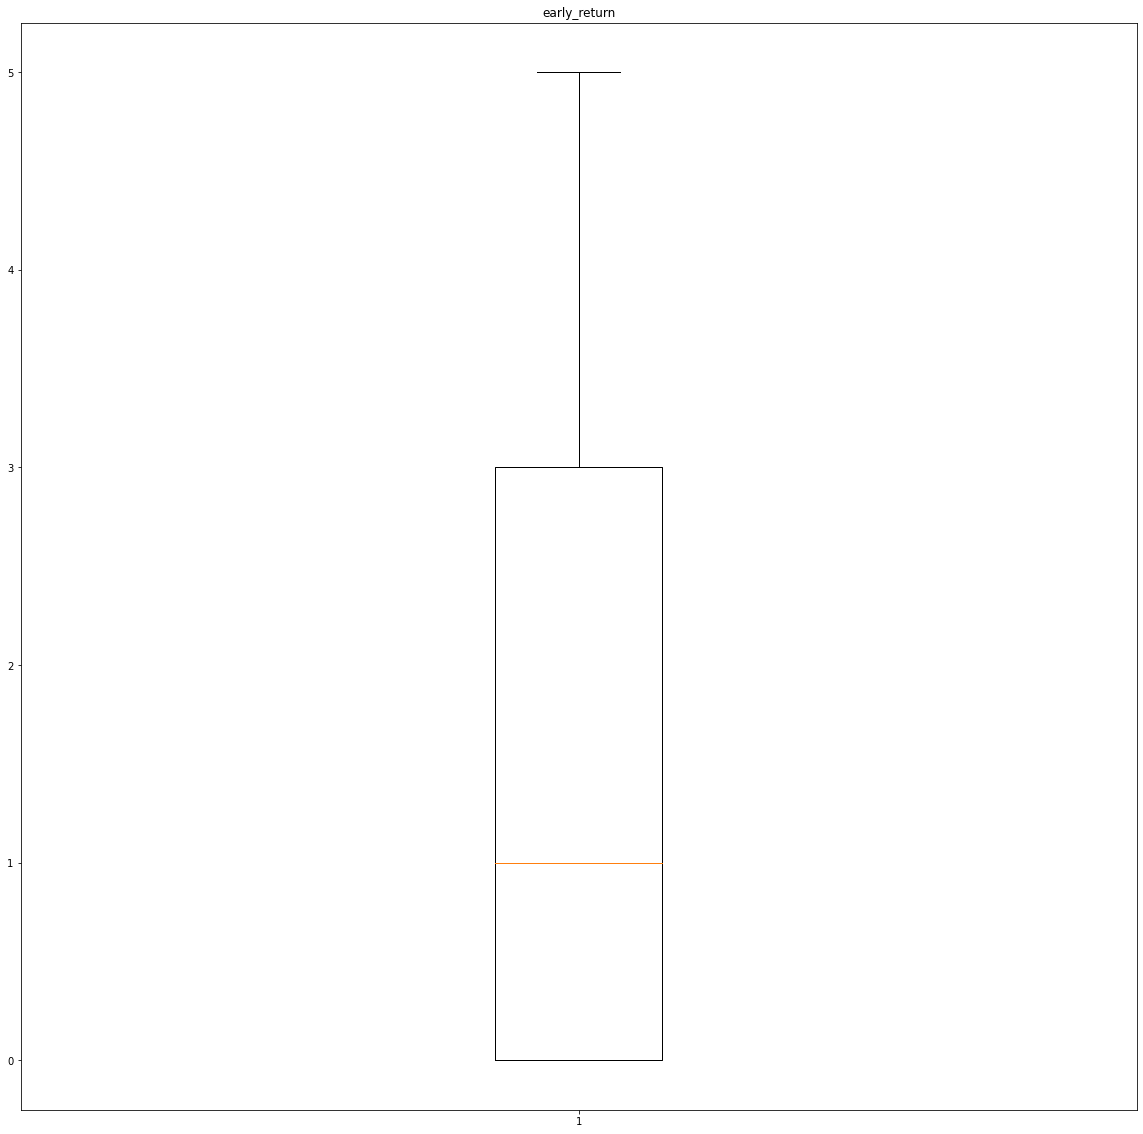

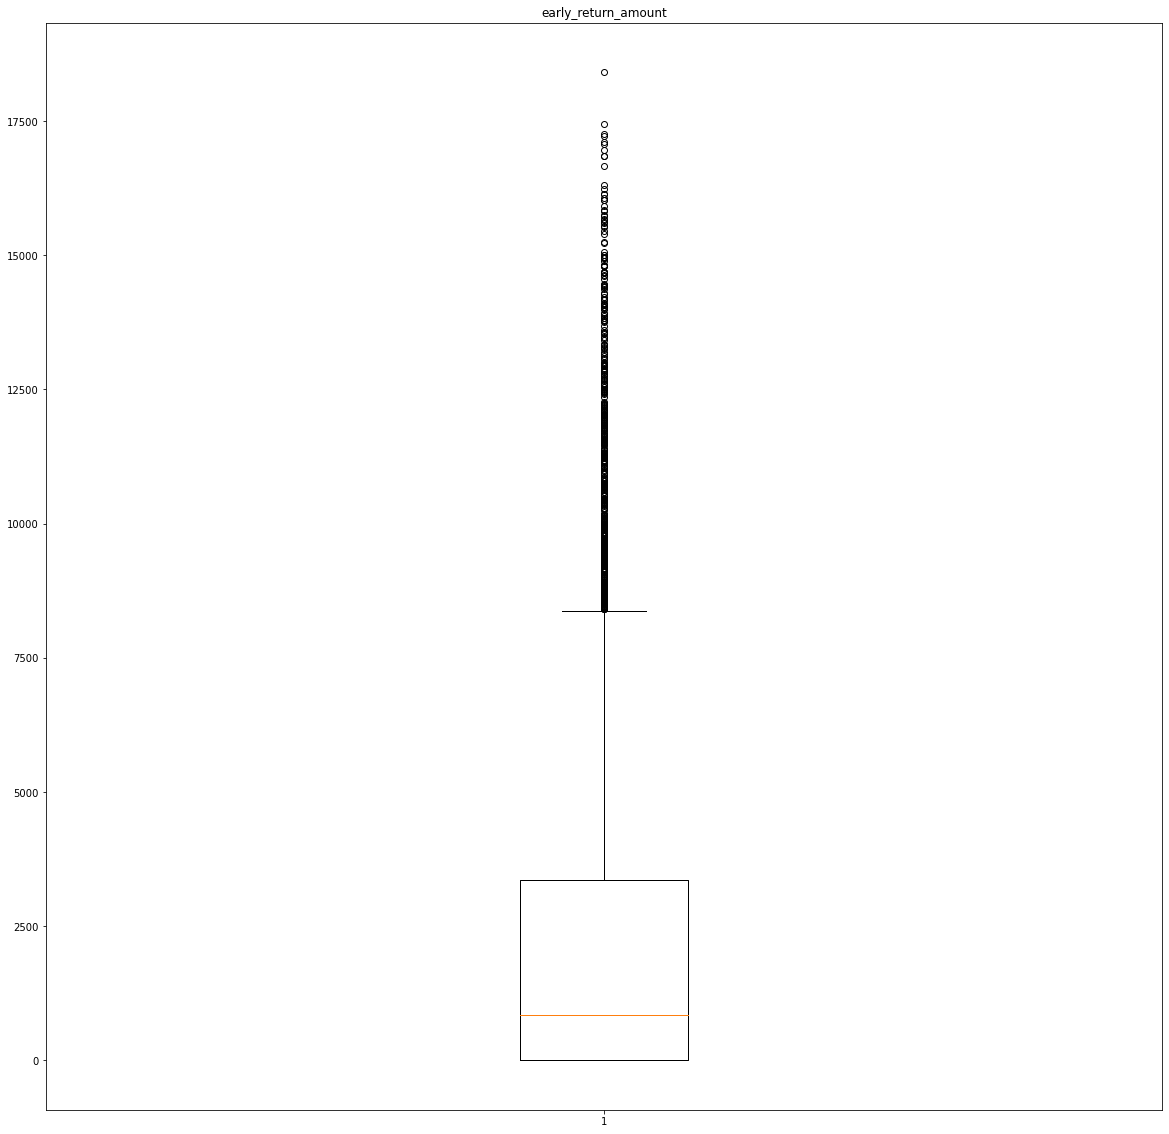

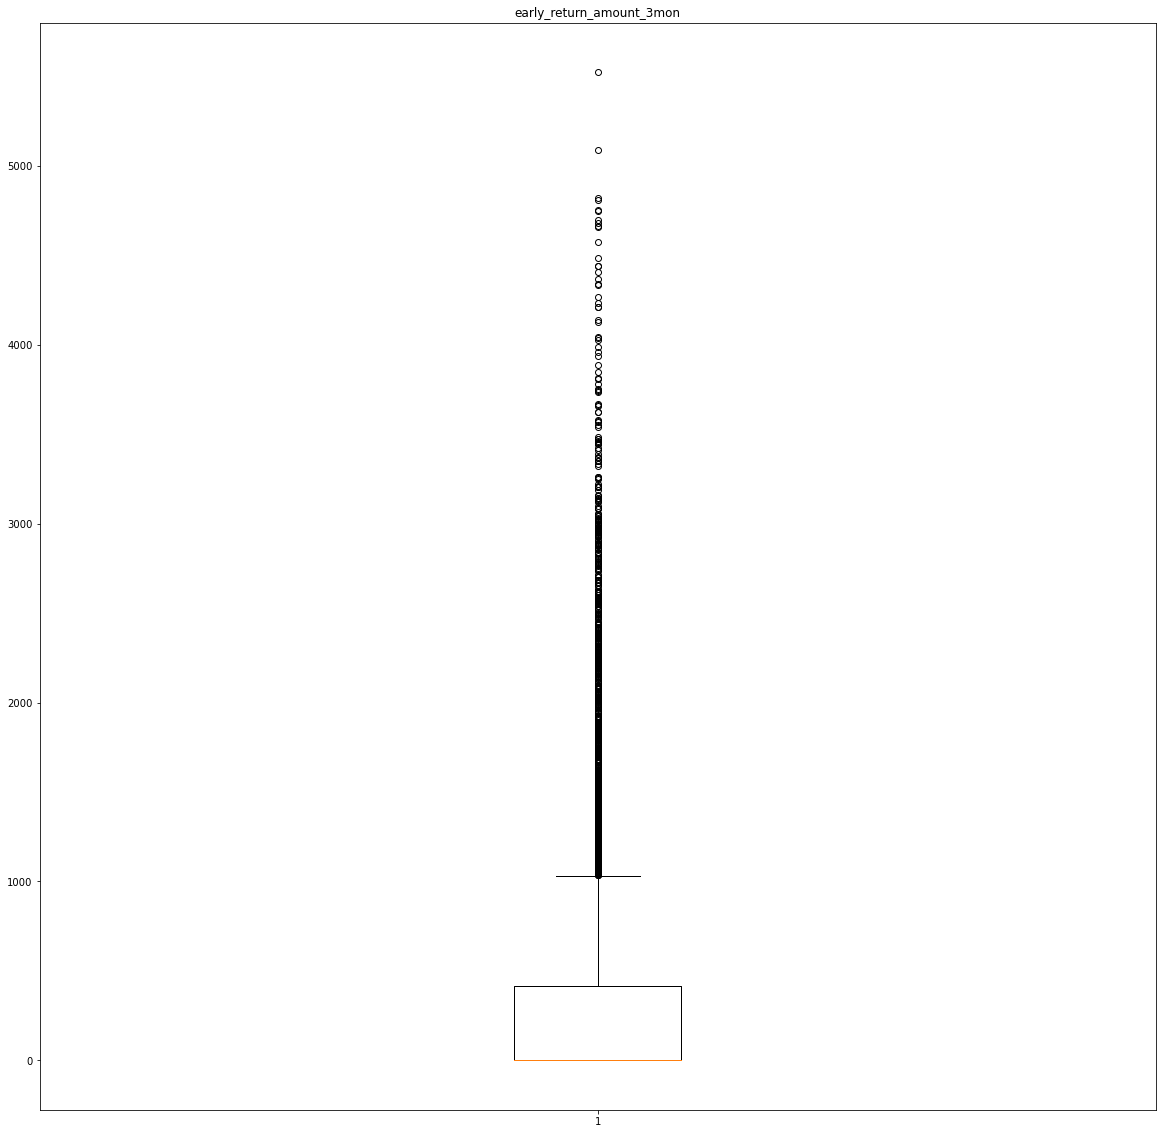

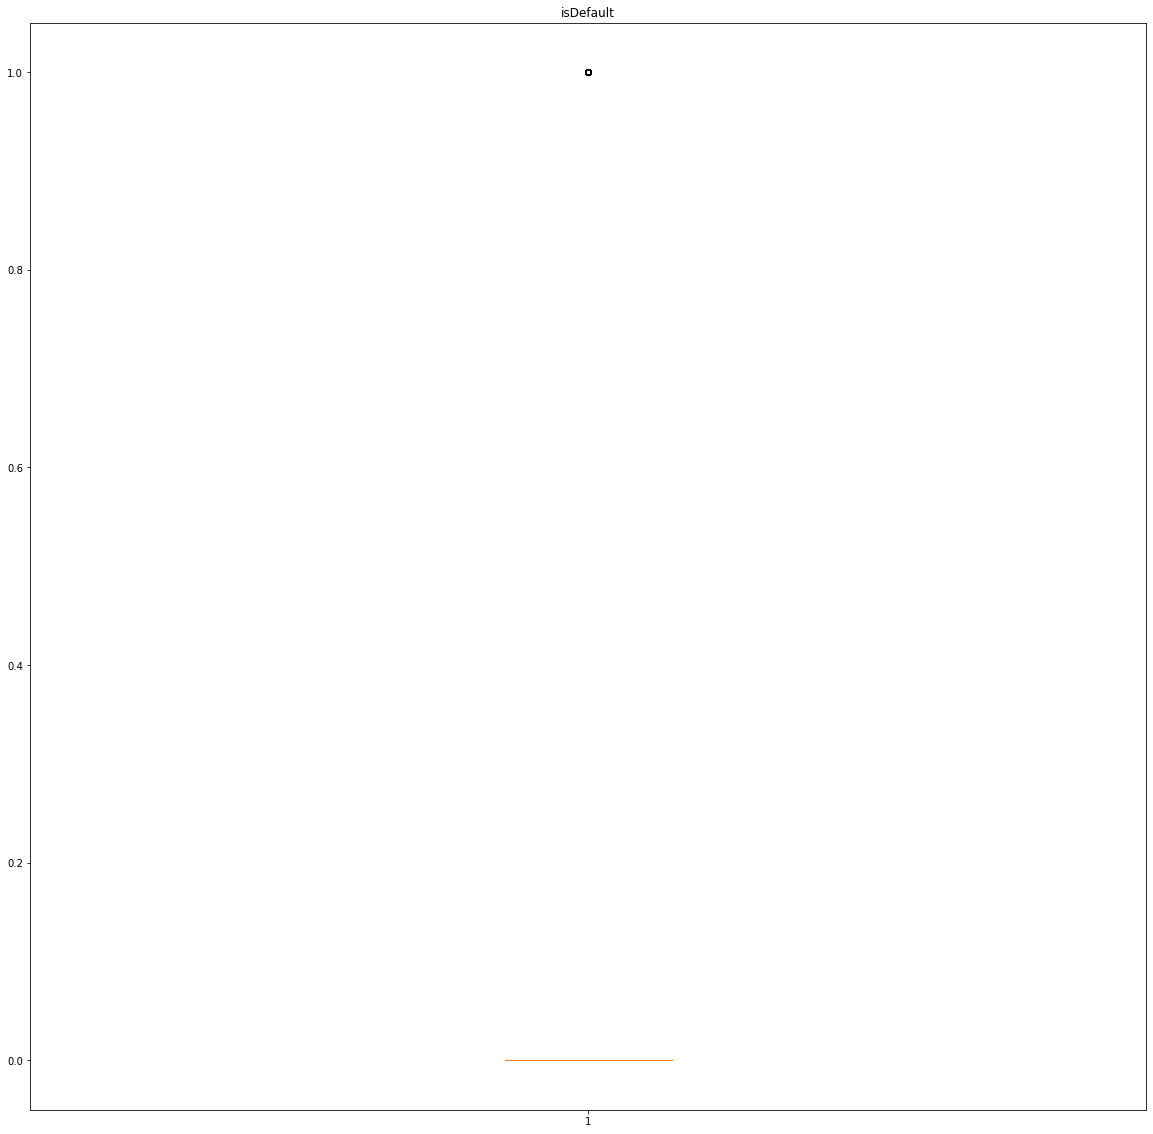

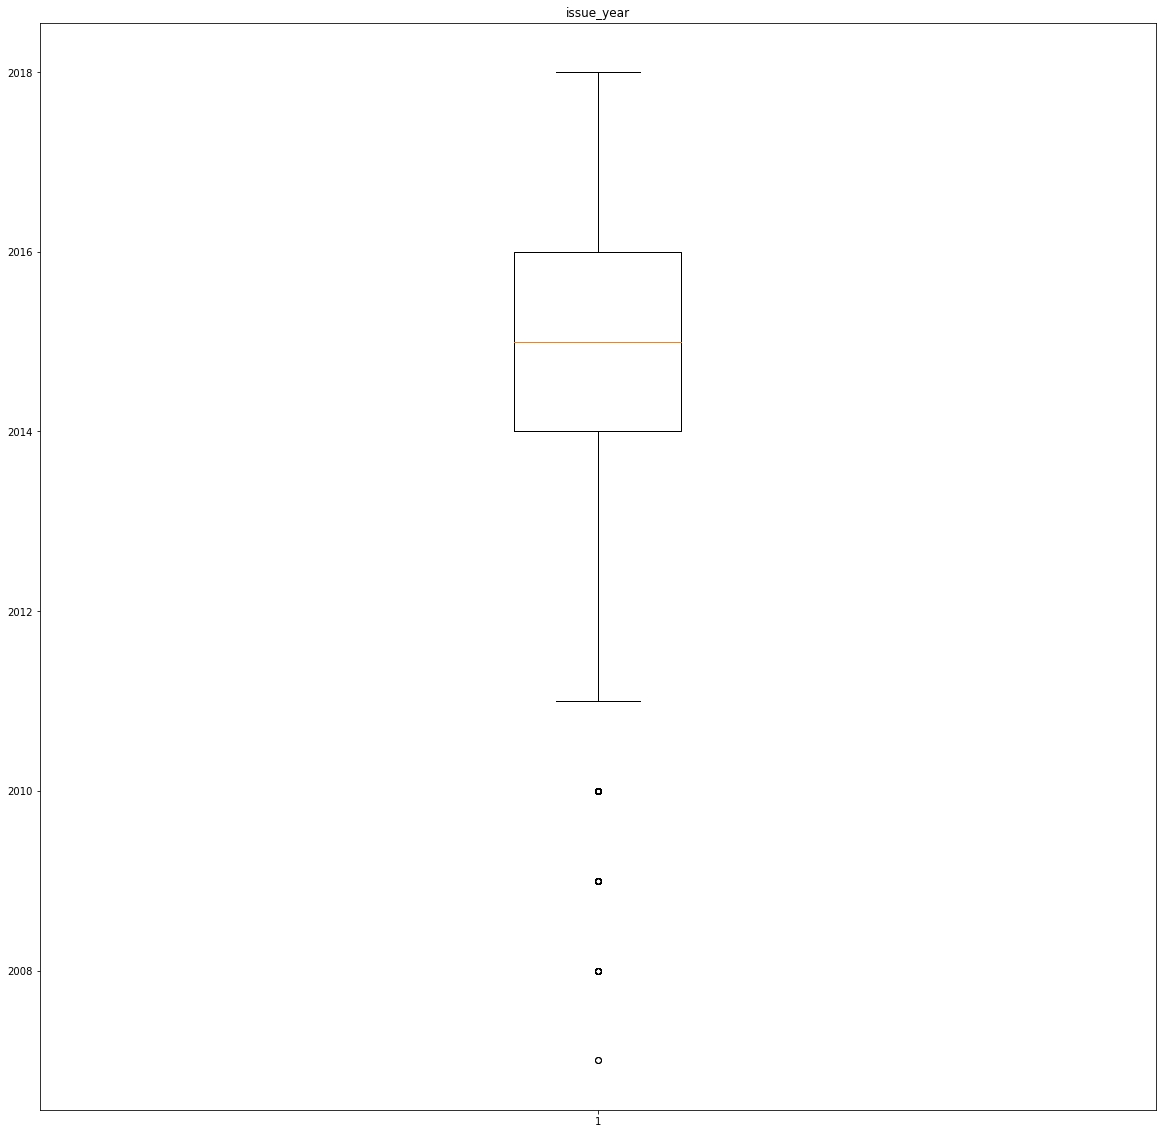

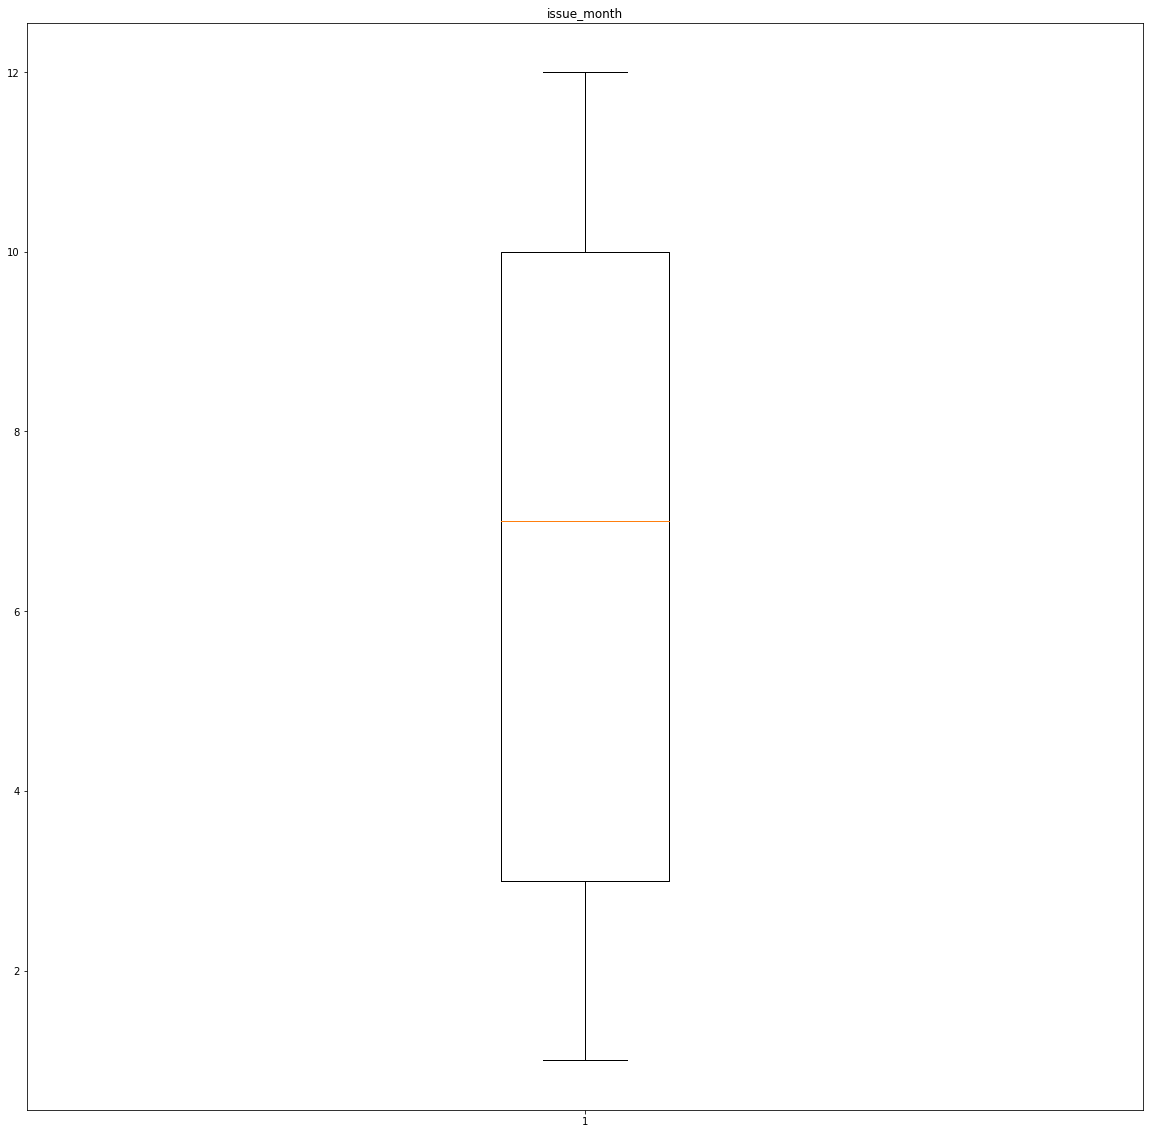

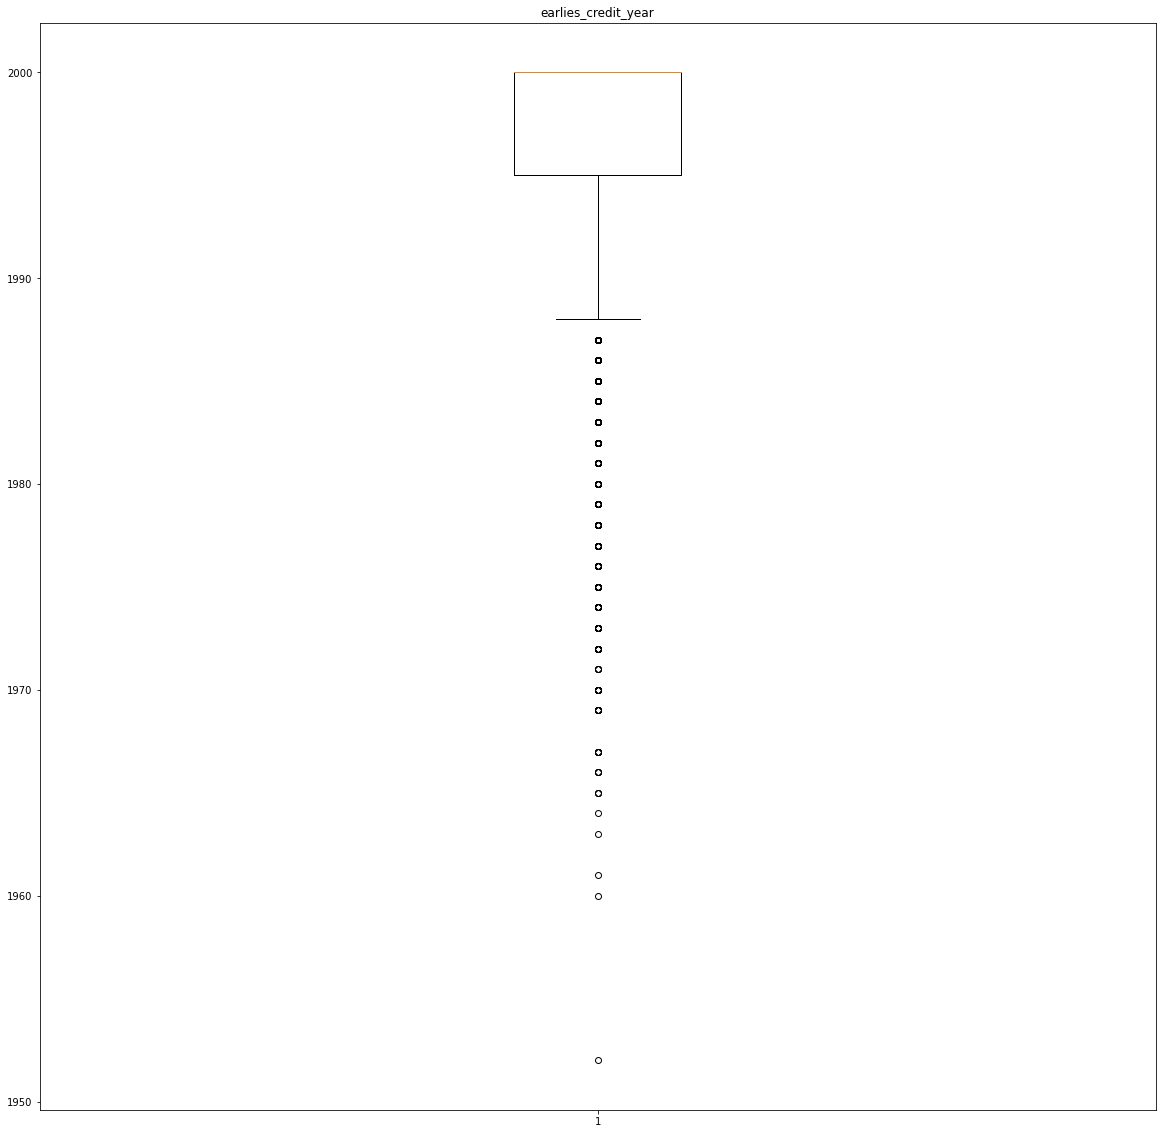

In [13]:
for i in range(40):
    plt.figure(figsize=(20,20))
    plt.title(data1.columns[i])
    plt.boxplot(data1.iloc[:,i],showfliers=True)
    plt.savefig('./boxplot/{0}.png'.format(i))
    plt.show()

使用孤立森林检测异常。

In [14]:
iforest=es.IsolationForest(n_estimators=100, max_samples='auto',
                          contamination=0.005,
                          bootstrap=False,)
index=set('')
for i in data1.columns.values.tolist():
    if (i!='loan_id') and (i!='user_id'):        
        tmp=pd.Series(iforest.fit_predict(data1[[i]].values))
        index.update(tmp[tmp==-1].index.values)
print('outliers number:',len(index))
print('outliers number ratio',len(index)/data1.shape[0])
#data1=data1.drop(list(index))

outliers number: 885
outliers number ratio 0.0885


删除部分影响结果的异常值。删除了debt_loan_radio的最高值与次高值，house_exist的最高值，recircle_b的最高值。

In [15]:
data1=data1.drop(data1[data1['debt_loan_ratio'].max()==data1['debt_loan_ratio']].index.values)
data1=data1.drop(data1[data1['debt_loan_ratio'].max()==data1['debt_loan_ratio']].index.values)
data1=data1.drop(data1[data1['recircle_b']>500000].index.values)
data1=data1.drop(data1[data1['house_exist'].max()==data1['house_exist']].index.values)

## 数据相关性探索

检测皮尔森相关性

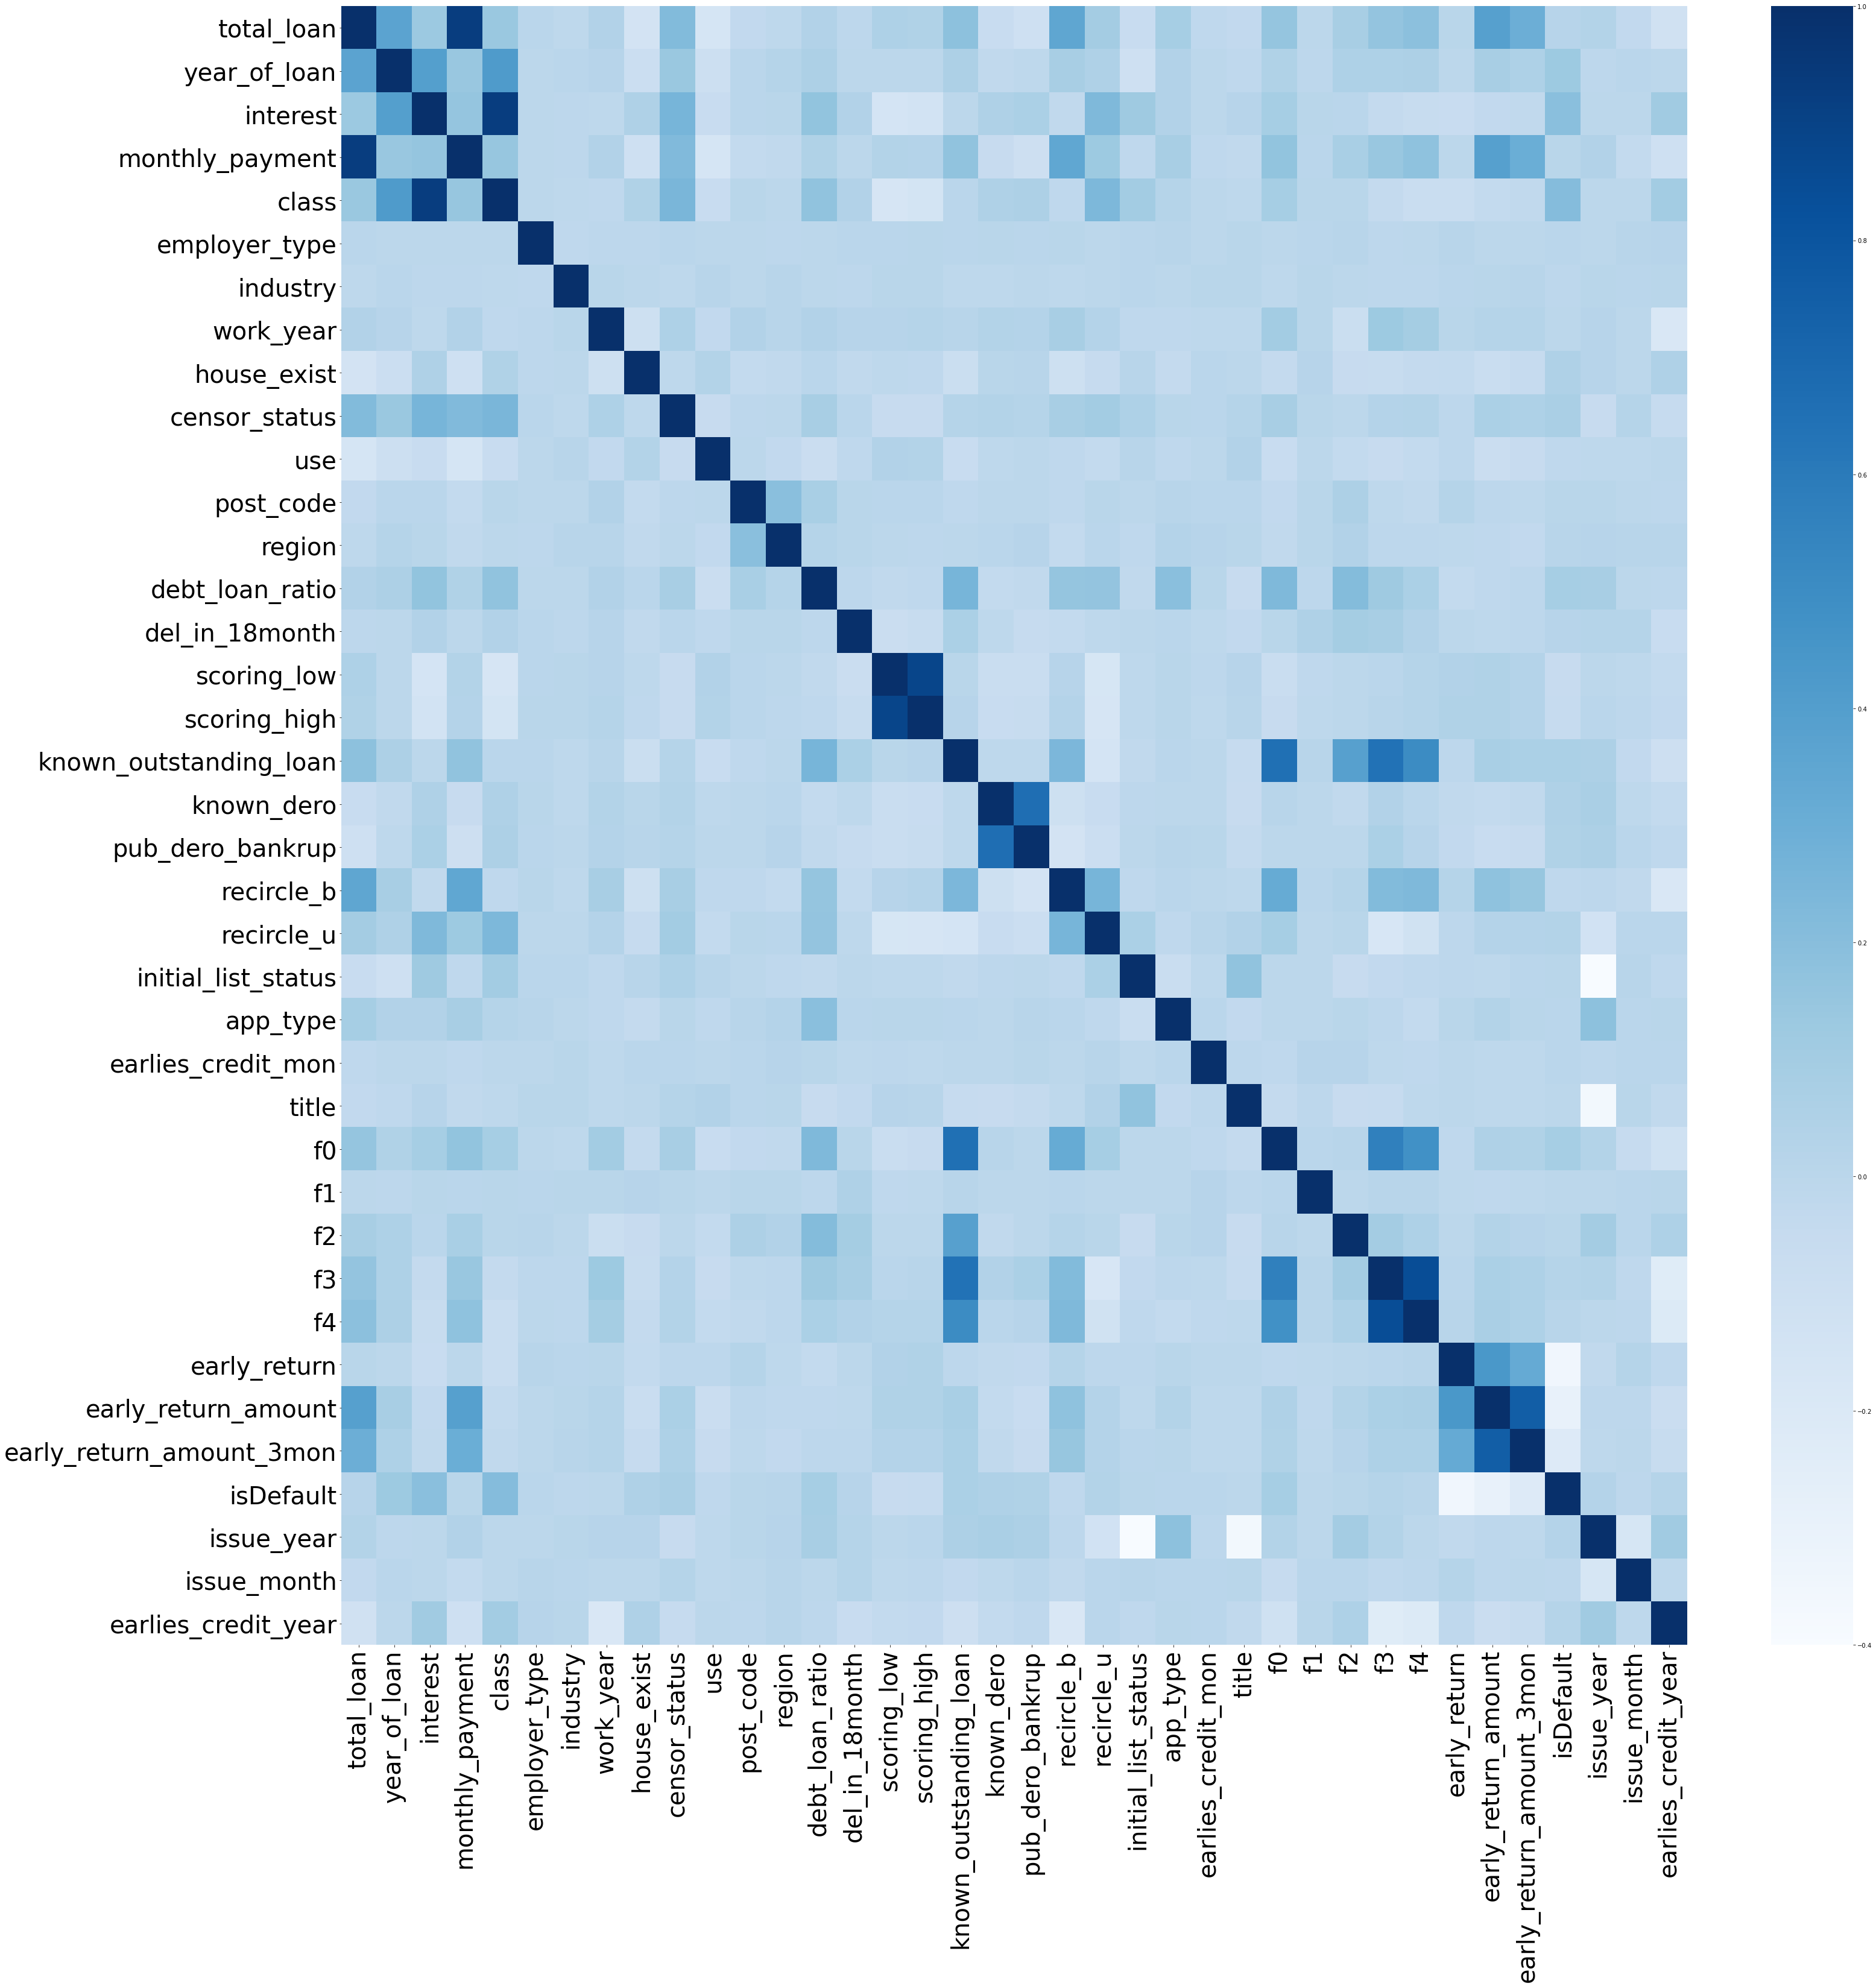

In [16]:
data1=data1.drop('loan_id',axis=1)
data1=data1.drop('user_id',axis=1)
data1_corr=data1.corr()
plt.figure(figsize=(50,50))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(data1_corr, cmap="Blues", fmt='.2g')
plt.savefig('./data_corr.png')
plt.show()

绘制相关性较强的属性散点图寻找规律。

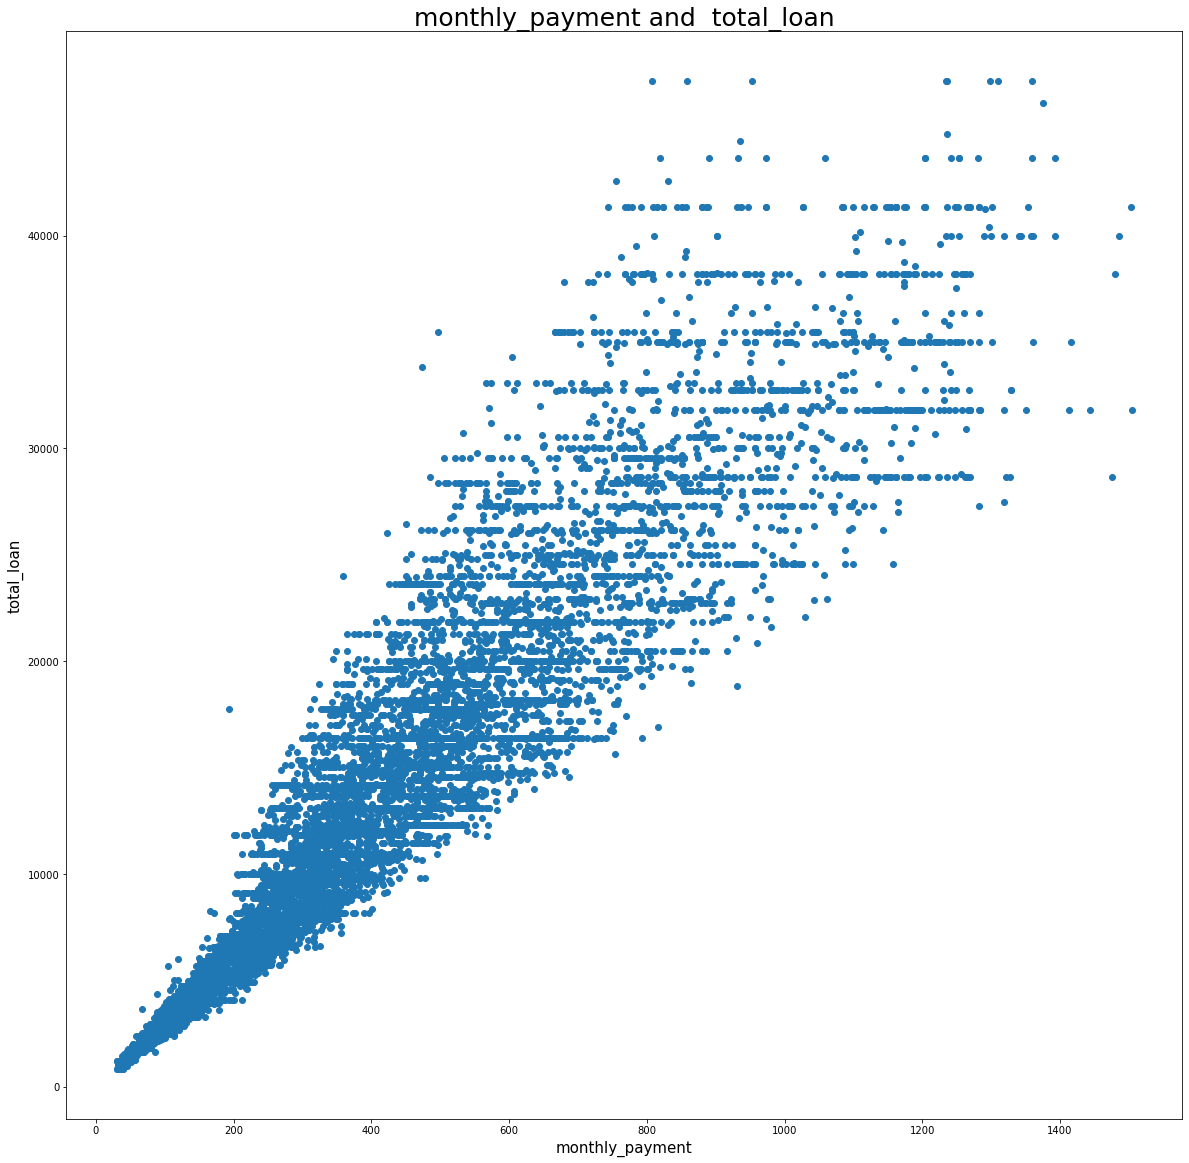

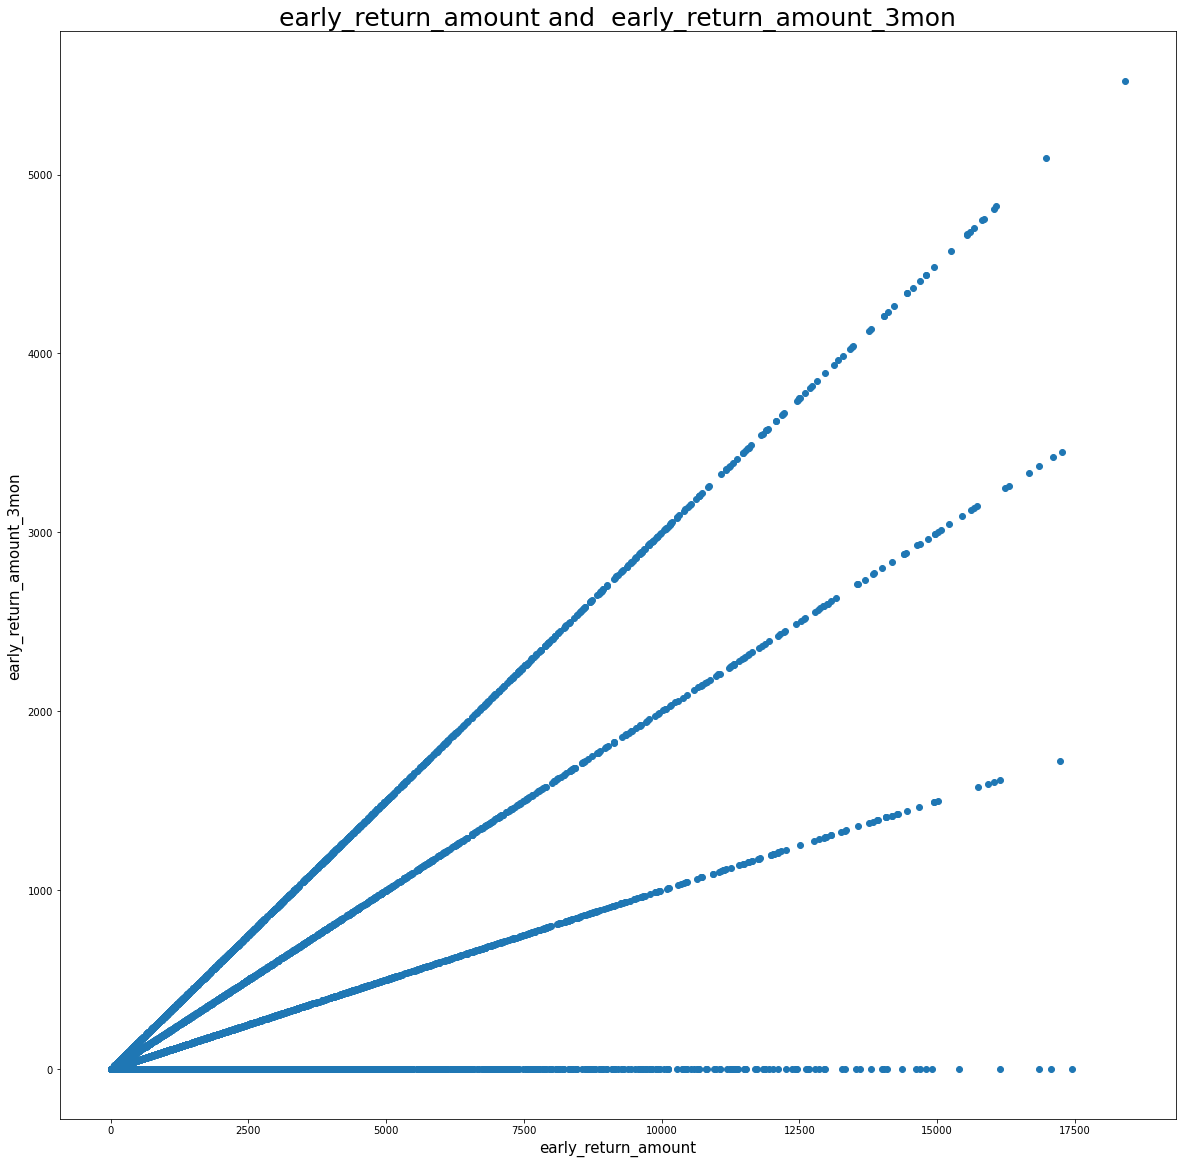

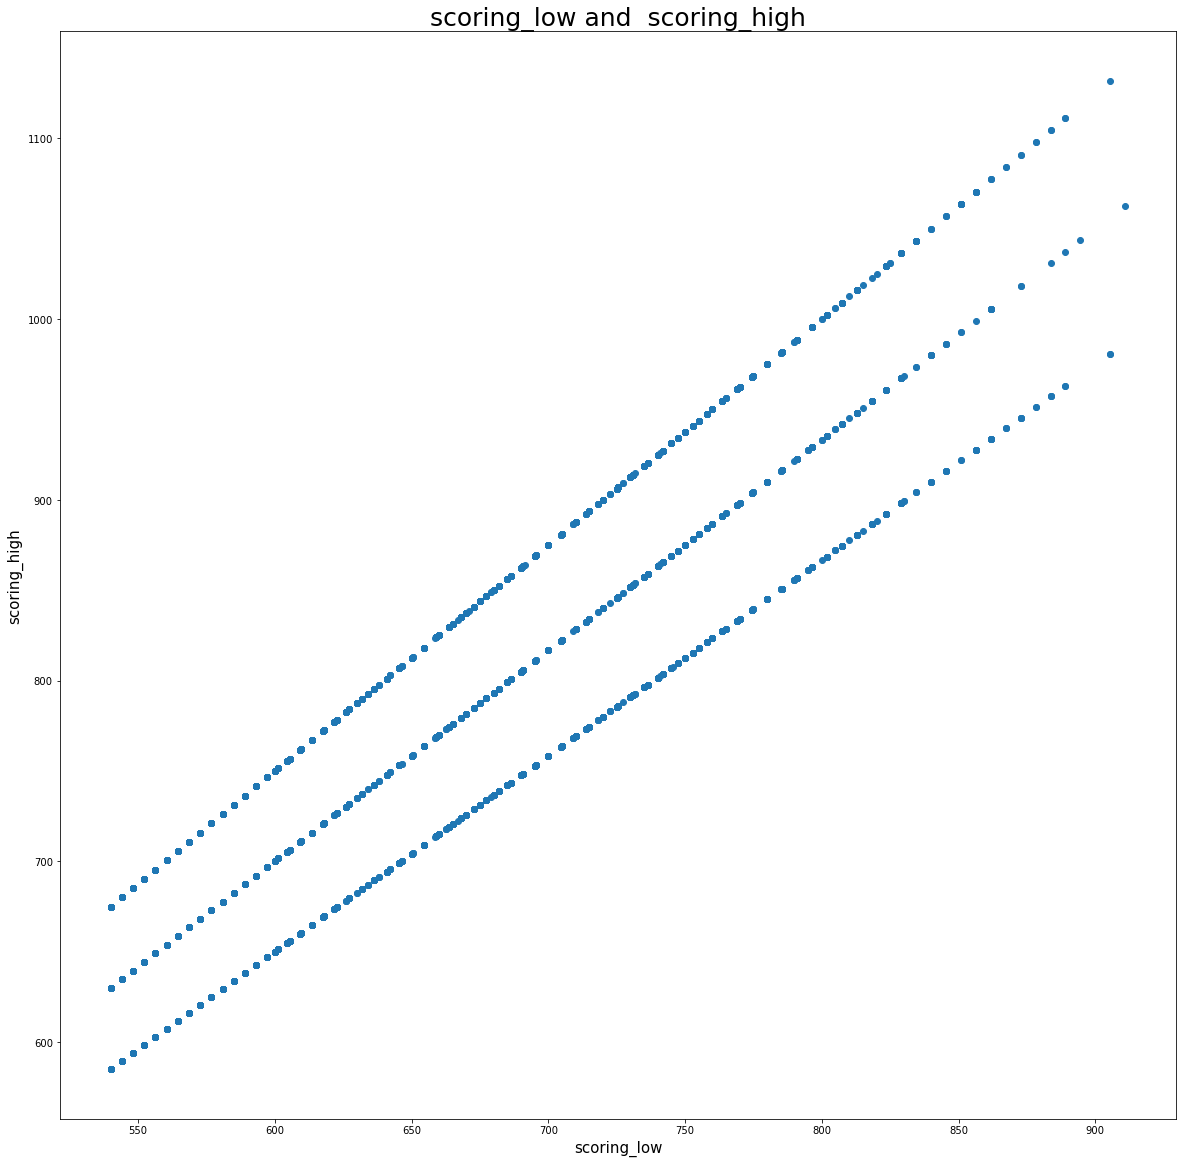

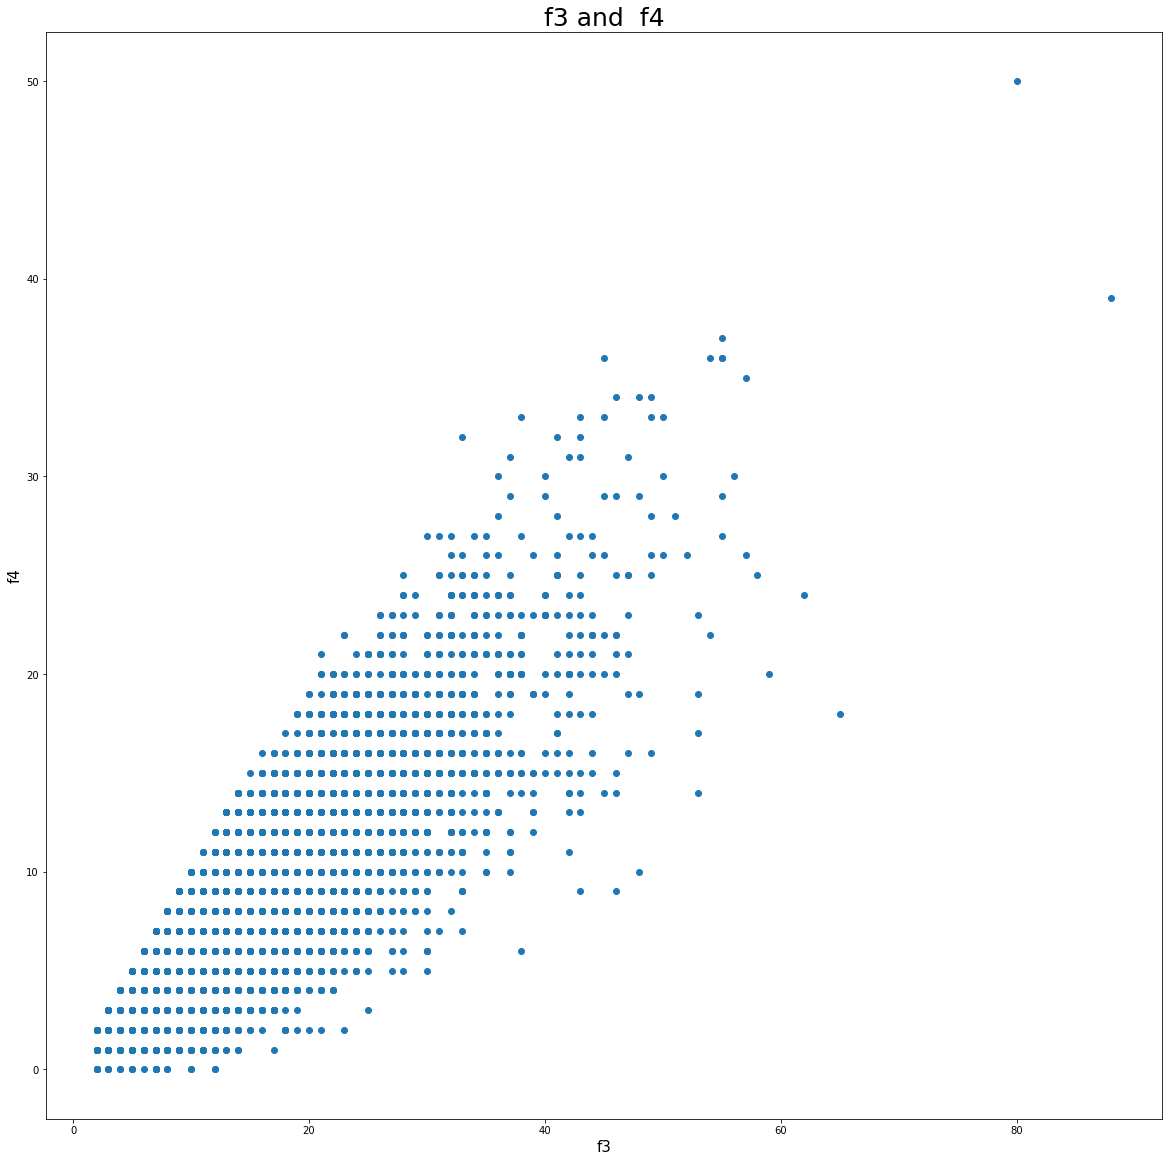

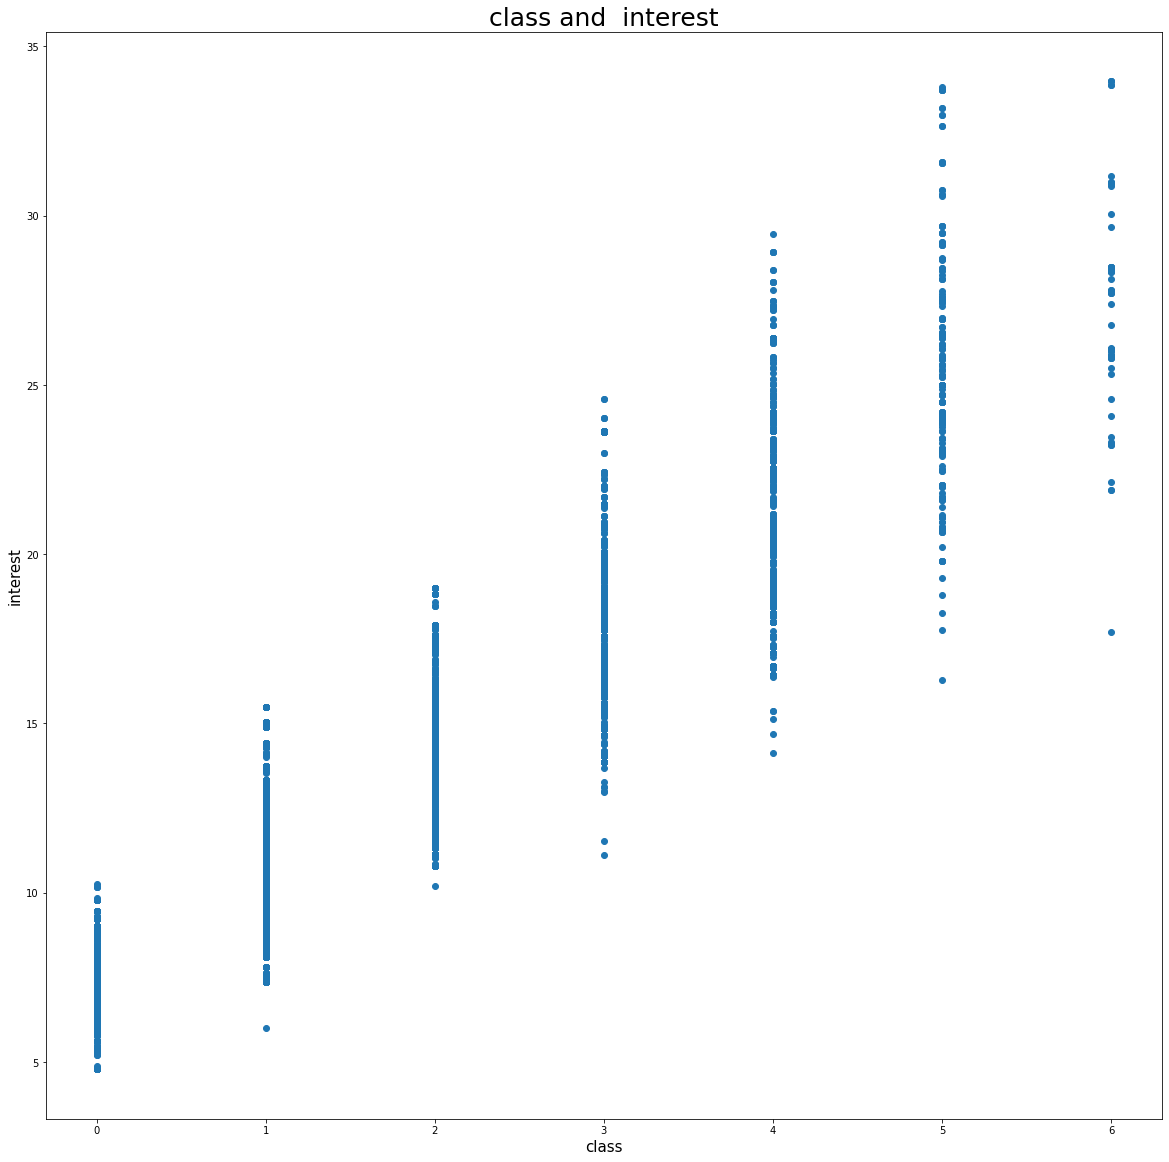

In [17]:
list1=['monthly_payment','early_return_amount','scoring_low','f3','class']
list2=['total_loan','early_return_amount_3mon','scoring_high','f4','interest']
for i,j in zip(list1,list2):
    plt.figure(figsize=(20,20))
    plt.title(i+' and  '+j,fontsize=25)
    plt.scatter(data1[i],data1[j])
    plt.xlabel(i,fontsize=15)
    plt.ylabel(j,fontsize=15)
    plt.savefig('D:\\各种任务作业大集合\\数据挖掘大作业\\boxplot\\'+i+' and  '+j+'.png')
    plt.show()

数字归一化，采用Z-score进行规约

In [18]:
data2:pd.DataFrame=(data1-data1.mean())/data1.std()